In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import obspy
from obspy.clients.fdsn import Client
ap = Client('IRIS')
from matplotlib.colors import LogNorm
from obspy import Stream
from obspy.geodetics import gps2dist_azimuth

In [2]:
# setting up the station inventory
inv = ap.get_stations(network='*', station="BYRD,MECK,STEW,UNGL,WHIT", level='response', channel='BHZ,BHN,BHE', starttime=obspy.UTCDateTime(2016,1,1,1),
                      endtime = obspy.UTCDateTime(2020,1,1,1), maxlatitude=-63)
print(inv)

sta_lats = []
sta_lons = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        sta_lats.append(inv[i][j].latitude)
        sta_lons.append(inv[i][j].longitude)

print('Number of stations:', len(sta_lats))

# indexing the stations to a single variable

stations_flat = []
networks_flat = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        stations_flat.append(inv[i][j].code)
        networks_flat.append(inv[i].code)

print((stations_flat))
print(len(networks_flat))

bulk_stations = []

for i in range(len(sta_lats)):
    receiver_lat = sta_lats[i]
    receiver_lon = sta_lons[i]
    station_code = stations_flat[i]
    bulk_stations.append({"latitude": receiver_lat, "longitude": receiver_lon, "stationcode": station_code})

Inventory created at 2025-10-19T19:01:12.912100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (5):
			YT.BYRD (BYRD)
			YT.MECK (MECK)
			YT.STEW (STEW)
			YT.UNGL (Union Glacier)
			YT.WHIT (Whitmore Mountains)
		Channels (21):
			YT.BYRD..BHZ (3x), YT.BYRD..BHN (3x), YT.BYRD..BHE (3x), 
			YT.MECK..BHZ, YT.MECK..BHN, YT.MECK..BHE, YT.STEW..BHZ, 
			YT.STEW..BHN, YT.STEW..BHE, YT.UNGL..BHZ, YT.UNGL..BHN, 
			YT.UNGL..BHE, YT.WHIT..BHZ, YT.WHIT..BHN, YT.WHIT..BHE
Number of stations: 5
['BYRD', 'MECK', 'STEW', 'UNGL', 'WHIT']
5


Station: UNGL, Channel: BHZ


c:\Users\thele\anaconda3\envs\base2\Lib\site-packages\obspy\core\inventory\response.py:2318: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="lower center", ncol=3, fontsize='small')


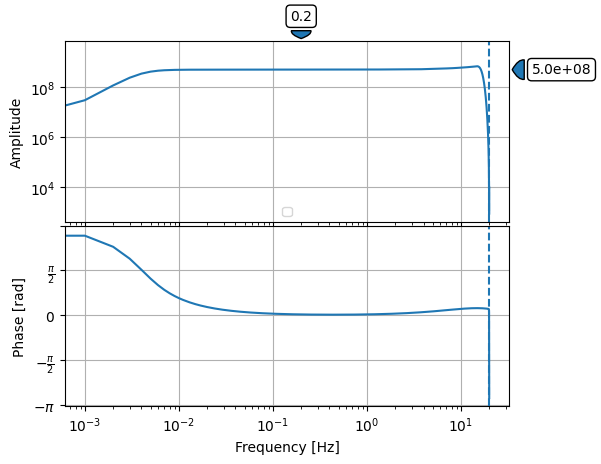

In [3]:

for net in inv.select(channel='BHZ'):
    if net.code == 'YT':
        for sta in net:
            if sta.code.startswith('UNGL'):
                for chan in sta:
                    if chan.code.startswith('BH'):
                        response = chan.response
                        paz = response.get_paz()
                        print(f"Station: {sta.code}, Channel: {chan.code}")
                        # print(f"Poles: {paz.poles}")
                        # print(f"Zeros: {paz.zeros}")
                        # Use response.response_stages to get filter info
                        for stage in response.response_stages:
                            if hasattr(stage, 'filter_type'):
                                print(f"Filter type: {stage.filter_type}")
                                print(f"Corner frequency: {getattr(stage, 'corner_frequency', 'N/A')}")
responses = response.plot(0.001)


In [4]:
# importing Son's events

son = pd.read_csv(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\Pham2025_submitted\TableS1.csv")
#son = son[son['quality_group'] == 'A'] # filtering to only the quality A events

lats = son['relocated_latitude'].tolist()
lons = son['relocated_longitude'].tolist()

det_lats = son['detected_latitude'].tolist()
det_lons = son['detected_longitude'].tolist()

mags = son['Ms_BB'].tolist()
times = son['relocated_time'].tolist()
qual_group = son['quality_group'].tolist()
ens = son['eff_nstations'].tolist()

#qualities = son['quality_group'].tolist()

son_date_format = '%Y-%m-%dT%H:%M:%S.000000Z'

years = []
months = []
days = []
for i in range(len(times)):
    years.append(int(datetime.strptime(times[i], son_date_format).strftime('%Y')))
    months.append(int(datetime.strptime(times[i], son_date_format).strftime('%m')))
    days.append(int(datetime.strptime(times[i], son_date_format).strftime('%d')))

In [5]:
# calculate the distance between two stations
def distance(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[0]

def back_azimuth(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[2]

In [6]:
# isolating the specific event
test = []

for i in range(len(times)):
    if times[i] == '2018-11-08T05:03:34.000000Z':
        test.append(i)
        event_lat = lats[i]
        event_lon = lons[i]
        event_time = times[i]
        event_mag = mags[i]
        event_year = years[i] + months[i]/12 + days[i]/365
        
test

[247]

In [7]:
signals = Stream()
signals.clear()

dist_infos, back_azs, begin_times, end_times, arrival_times = [], [], [], [], []

for i in range(len(bulk_stations)):
    dist_info = distance(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude']) / 1e3
    back_az = back_azimuth(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])
    try:
        time_to_arrive = dist_info / 2.95  # assuming average speed of 2.95 km/s
        begin_time = obspy.UTCDateTime(event_time) + time_to_arrive - 60*60
        end_time = obspy.UTCDateTime(event_time) + time_to_arrive + 50*60
        st = ap.get_waveforms(network=networks_flat[i], station=stations_flat[i], channel='BHZ,BHN,BHE', location='*', starttime=begin_time, endtime=end_time)
        st.remove_response(inv,output='DISP',taper=True, taper_fraction=0.1)
        st.detrend('linear')
        st.detrend('demean')
        st.taper(max_percentage=0.1) # original 0.1
        st.rotate('NE->RT', back_az)
        for tr in st:
            tr.stats.distance = dist_info*1000  # in meters
        signals += st
        dist_infos.append(dist_info)
        back_azs.append(back_az)
        begin_times.append(begin_time)
        end_times.append(end_time)
        arrival_times.append(obspy.UTCDateTime(event_time) + time_to_arrive)
        print(f"Got data for station {bulk_stations[i]['stationcode']}")
    except Exception as e:
        print(f"Could not get data for station {bulk_stations[i]['stationcode']}: {e}")

Got data for station BYRD
Got data for station MECK
Got data for station STEW
Got data for station UNGL
Got data for station WHIT


In [8]:
signals

15 Trace(s) in Stream:
YT.BYRD..BHT | 2018-11-08T04:06:53.674998Z - 2018-11-08T05:56:53.649998Z | 40.0 Hz, 264000 samples
YT.BYRD..BHR | 2018-11-08T04:06:53.674998Z - 2018-11-08T05:56:53.649998Z | 40.0 Hz, 264000 samples
YT.BYRD..BHZ | 2018-11-08T04:06:53.674998Z - 2018-11-08T05:56:53.649998Z | 40.0 Hz, 264000 samples
YT.MECK..BHT | 2018-11-08T04:09:04.125001Z - 2018-11-08T05:59:04.100001Z | 40.0 Hz, 264000 samples
YT.MECK..BHR | 2018-11-08T04:09:04.125000Z - 2018-11-08T05:59:04.100000Z | 40.0 Hz, 264000 samples
YT.MECK..BHZ | 2018-11-08T04:09:04.125000Z - 2018-11-08T05:59:04.100000Z | 40.0 Hz, 264000 samples
YT.STEW..BHT | 2018-11-08T04:09:29.324998Z - 2018-11-08T05:59:29.299998Z | 40.0 Hz, 264000 samples
YT.STEW..BHR | 2018-11-08T04:09:29.325000Z - 2018-11-08T05:59:29.300000Z | 40.0 Hz, 264000 samples
YT.STEW..BHZ | 2018-11-08T04:09:29.324998Z - 2018-11-08T05:59:29.299998Z | 40.0 Hz, 264000 samples
YT.UNGL..BHT | 2018-11-08T04:07:50.224998Z - 2018-11-08T05:57:50.199998Z | 40.0 Hz, 26

In [9]:
signals_filt = signals.copy()

for tr in signals_filt:
    tr.filter('bandpass', freqmin=0.01, freqmax=1, corners=4, zerophase=True)
    tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)

signals_filt

15 Trace(s) in Stream:
YT.BYRD..BHT | 2018-11-08T04:10:13.674998Z - 2018-11-08T05:53:33.649998Z | 40.0 Hz, 248000 samples
YT.BYRD..BHR | 2018-11-08T04:10:13.674998Z - 2018-11-08T05:53:33.649998Z | 40.0 Hz, 248000 samples
YT.BYRD..BHZ | 2018-11-08T04:10:13.674998Z - 2018-11-08T05:53:33.649998Z | 40.0 Hz, 248000 samples
YT.MECK..BHT | 2018-11-08T04:12:24.125001Z - 2018-11-08T05:55:44.100001Z | 40.0 Hz, 248000 samples
YT.MECK..BHR | 2018-11-08T04:12:24.125000Z - 2018-11-08T05:55:44.100000Z | 40.0 Hz, 248000 samples
YT.MECK..BHZ | 2018-11-08T04:12:24.125000Z - 2018-11-08T05:55:44.100000Z | 40.0 Hz, 248000 samples
YT.STEW..BHT | 2018-11-08T04:12:49.324998Z - 2018-11-08T05:56:09.299998Z | 40.0 Hz, 248000 samples
YT.STEW..BHR | 2018-11-08T04:12:49.325000Z - 2018-11-08T05:56:09.300000Z | 40.0 Hz, 248000 samples
YT.STEW..BHZ | 2018-11-08T04:12:49.324998Z - 2018-11-08T05:56:09.299998Z | 40.0 Hz, 248000 samples
YT.UNGL..BHT | 2018-11-08T04:11:10.224998Z - 2018-11-08T05:54:30.199998Z | 40.0 Hz, 24

In [10]:
secs_offset = [0, 56, 76, 130, 155]

In [11]:
signals_geq_filt = signals.copy()

for tr in signals_geq_filt:
    tr.filter('bandpass', freqmin=0.04, freqmax=0.06, corners=4, zerophase=True)
    tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)

In [12]:
secs_offset = [0, 130, 155, 56, 76]

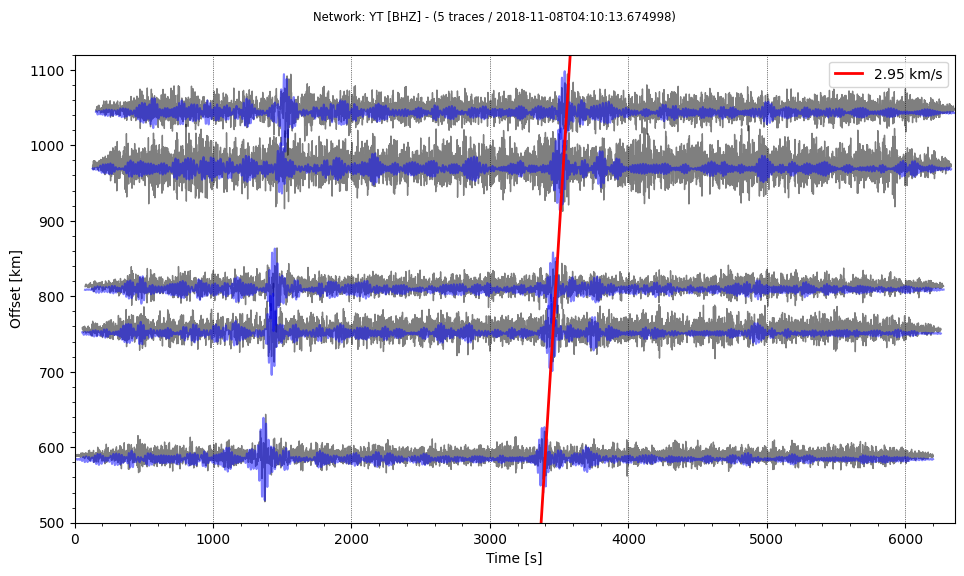

In [13]:
import matplotlib.dates as mdates

# Plot section and get the figure
fig = signals_filt.select(component='Z').plot(type='section', orientation='horizontal', show=False)

# Get the correct axes
ax = fig.axes[0]

# Get event time as matplotlib date
event_time_dt = obspy.UTCDateTime(event_time).datetime
event_time_num = mdates.date2num(event_time_dt)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    # Calculate time axis in seconds since event
    t = tr.times()
    # Calculate distance in km
    y = tr.stats.distance / 1000
    # Offset for plotting (match ObsPy's section plot style)
    ax.plot(t+secs_offset[i], np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 55, color='blue', alpha=0.5)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3200 # event time relative to start of BYRD

# Plot the red line on the same axes
ax.plot(t, y, 'r-', lw=2, label='2.95 km/s')

ax.set_ylim(500, 1120)

ax.legend()

# Instead of plt.show(), display the figure directly in Jupyter:
fig.canvas.draw()
fig

In [14]:
son = son[son['quality_group'] == 'A'] # filtering to only the quality A events

lats = son['relocated_latitude'].tolist()
lons = son['relocated_longitude'].tolist()
mags = son['Ms_BB'].tolist()
times = son['relocated_time'].tolist()
#qualities = son['quality_group'].tolist()

son_date_format = '%Y-%m-%dT%H:%M:%S.000000Z'

years = []
months = []
days = []
for i in range(len(times)):
    years.append(int(datetime.strptime(times[i], son_date_format).strftime('%Y')))
    months.append(int(datetime.strptime(times[i], son_date_format).strftime('%m')))
    days.append(int(datetime.strptime(times[i], son_date_format).strftime('%d')))

son

evcode  relocated_latitude  relocated_longitude  \
3    201006171002              -75.21              -107.85   
5    201012051521              -75.38              -106.93   
6    201012150852              -74.72              -137.18   
7    201012200336              -75.63              -108.29   
8    201101081003              -74.72              -137.18   
..            ...                 ...                  ...   
332  202010090549              -75.38              -107.21   
333  202010121458              -75.43              -106.61   
334  202010180427              -75.44              -106.44   
358  202207221322              -75.34              -108.29   
365  202306221811              -75.38              -107.21   

                  relocated_time  max_cc  eff_nstations  Ms_BB  \
3    2010-06-17T10:02:05.000000Z    0.86           2.29   2.46   
5    2010-12-05T15:21:04.000000Z    0.79           2.32   2.17   
6    2010-12-15T08:52:18.000000Z    0.92           1.96   2.61   
7    2010-12-20T03:36:20.000000Z    0.73           2.13   2.22   
8    2011-01-08T10:03:15.000000Z    0.90           1.96   2.75   
..                           ...     ...            ...    ...   
332  2020-10-09T05:49:48.000000Z    0.92           5.96   2.23   
333  2020-10-12T14:58:08.000000Z    0.89           6.10   2.57   
334  2020-10-18T04:27:25.000000Z    0.89           6.14   2.43   
358  2022-07-22T13:22:46.000000Z    0.83           5.72   2.46   
365  2023-06-22T18:11:05.000000Z    0.90           5.31   2.37   

                   detected_time  detected_latitude  detected_longitude  \
3    2010-06-17T10:02:06.000000Z             -75.09             -107.88   
5    2010-12-05T15:21:02.000000Z             -75.22             -106.19   
6    2010-12-15T08:52:14.000000Z             -74.46             -137.39   
7    2010-12-20T03:36:34.000000Z             -75.95             -109.03   
8    2011-01-08T10:03:10.000000Z             -74.46             -137.39   
..                           ...                ...                 ...   
332  2020-10-09T05:49:58.000000Z             -75.66             -106.70   
333  2020-10-12T14:58:16.000000Z             -75.66             -106.70   
334  2020-10-18T04:27:26.000000Z             -75.22             -106.19   
358  2022-07-22T13:22:52.000000Z             -75.52             -108.43   
365  2023-06-22T18:11:12.000000Z             -75.52             -108.43   

    quality_group  usgs_event  poli_event  csf_az       csf_amp  
3               A       False       False    14.0  1.921205e+11  
5               A       False       False   -26.0  1.889637e+11  
6               A       False       False   164.0  5.372518e+11  
7               A       False       False     NaN           NaN  
8               A       False       False   162.0  6.156937e+11  
..            ...         ...         ...     ...           ...  
332             A       False       False    -8.0  2.342790e+11  
333             A       False       False    -2.0  4.427749e+11  
334             A       False       False     4.0  4.024750e+11  
358             A       False       False     NaN           NaN  
365             A       False       False    24.0  3.853117e+11  

[90 rows x 15 columns]

In [15]:
# PIG region:
PIG_lats, PIG_lons, PIG_mags, PIG_times, PIG_years = [], [], [], [], []

for i in range(len(lats)):
    if lats[i] <= -74 and lats[i] >= -76 and lons[i] <= -97 and lons[i] >= -103:
        PIG_lats.append(lats[i])
        PIG_lons.append(lons[i])
        PIG_mags.append(mags[i])
        PIG_times.append(times[i])
        PIG_years.append(years[i] + months[i]/12 + days[i]/365)
        
print('PIG events:', len(PIG_lats))
print('PIG times', PIG_times)

PIG events: 4
PIG times ['2016-01-03T04:57:45.000000Z', '2016-01-10T19:23:27.000000Z', '2016-01-17T02:01:56.000000Z', '2018-06-30T20:57:07.000000Z']


In [16]:
# isolating the specific event
test = []

for i in range(len(times)):
    if times[i] == '2016-01-10T19:23:27.000000Z':
        test.append(i)
        event_lat = lats[i]
        event_lon = lons[i]
        event_time = times[i]
        event_mag = mags[i]
        event_year = years[i] + months[i]/12 + days[i]/365
        
test2 = []

for i in range(len(times)):
    if times[i] == '2016-01-03T04:57:45.000000Z':
        test2.append(i)
        event2_lat = lats[i]
        event2_lon = lons[i]
        event2_time = times[i]
        event2_mag = mags[i]
        event2_year = years[i] + months[i]/12 + days[i]/365
        
test, test2

([48], [47])

In [17]:
ap = Client('IRIS')

# we will start with just LH stations, but if this is kind of terrible talk with Son about adding more
inv_LH = ap.get_stations(network='*', station="RS14,BEAR,HOWD,KOLR,MECK,THUR,UNGL,WHIT", level='response', channel='BHZ', starttime=obspy.UTCDateTime(2016,1,1,1),
                      endtime = obspy.UTCDateTime(2017,1,1,1), maxlatitude=-63)
print(inv_LH)

sta_lats = []
sta_lons = []
for i in range(len(inv_LH)):
    for j in range(len(inv_LH[i])):
        sta_lats.append(inv_LH[i][j].latitude)
        sta_lons.append(inv_LH[i][j].longitude)

print('Number of stations:', len(sta_lats))

stations_flat = []
networks_flat = []
for i in range(len(inv_LH)):
    for j in range(len(inv_LH[i])):
        stations_flat.append(inv_LH[i][j].code)
        networks_flat.append(inv_LH[i].code)

print((stations_flat))
print(len(networks_flat))

bulk_stations = []

for i in range(len(sta_lats)):
    receiver_lat = sta_lats[i]
    receiver_lon = sta_lons[i]
    station_code = stations_flat[i]
    bulk_stations.append({"latitude": receiver_lat, "longitude": receiver_lon, "stationcode": station_code})

Inventory created at 2025-10-19T19:02:06.097900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (2):
			XH, YT
		Stations (8):
			XH.RS14 (Ross Ice Shelf - RS14)
			YT.BEAR (Bear Peninsula)
			YT.HOWD (Howard Nunatak)
			YT.KOLR (KOLR)
			YT.MECK (MECK)
			YT.THUR (Thurston Island)
			YT.UNGL (Union Glacier)
			YT.WHIT (Whitmore Mountains)
		Channels (8):
			XH.RS14..BHZ, YT.BEAR..BHZ, YT.HOWD..BHZ, YT.KOLR..BHZ, 
			YT.MECK..BHZ, YT.THUR..BHZ, YT.UNGL..BHZ, YT.WHIT..BHZ
Number of stations: 8
['RS14', 'BEAR', 'HOWD', 'KOLR', 'MECK', 'THUR', 'UNGL', 'WHIT']
8


In [18]:
signals = Stream()
signals.clear()

dist_infos, back_azs, begin_times, end_times, arrival_times = [], [], [], [], []

for i in range(len(bulk_stations)):
    dist_info = distance(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude']) / 1e3
    if dist_info < 1000:  # Only consider stations within 1000 km
        back_az = back_azimuth(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])
        try:
            time_to_arrive = dist_info / 2.95  # assuming average speed of 2.95 km/s
            begin_time = obspy.UTCDateTime(event_time) - 60*60
            end_time = obspy.UTCDateTime(event_time) + 50*60
            st = ap.get_waveforms(network=networks_flat[i], station=stations_flat[i], channel='BHZ', location='*', starttime=begin_time, endtime=end_time)
            st.remove_response(inv_LH,output='DISP',taper=True, taper_fraction=0.1)
            st.detrend('linear')
            st.detrend('demean')
            st.taper(max_percentage=0.1) # original 0.1
            #st.rotate('NE->RT', back_az)
            for tr in st:
                tr.stats.distance = dist_info*1000  # in meters
                if not hasattr(tr.stats, "coordinates"):
                    tr.stats.coordinates = {}
                tr.stats.coordinates["latitude"] = bulk_stations[i]['latitude']
                tr.stats.coordinates["longitude"] = bulk_stations[i]['longitude']
            signals += st
            dist_infos.append(dist_info)
            back_azs.append(back_az)
            begin_times.append(begin_time)
            end_times.append(end_time)
            arrival_times.append(obspy.UTCDateTime(event_time) + time_to_arrive)
            print(f"Got data for station {bulk_stations[i]['stationcode']}")
        except Exception as e:
            print(f"Could not get data for station {bulk_stations[i]['stationcode']}: {e}")

Got data for station RS14
Got data for station BEAR
Got data for station HOWD
Got data for station KOLR
Got data for station MECK
Got data for station THUR
Got data for station UNGL
Got data for station WHIT


In [19]:
dist_infos

[999.1153886457669,
 297.0145532764802,
 461.53745223522895,
 511.4969540877002,
 837.183673145534,
 356.34470267579985,
 667.0597999650943,
 807.5907446210934]

In [20]:
signals

8 Trace(s) in Stream:
XH.RS14..BHZ | 2016-01-10T18:23:27.000000Z - 2016-01-10T20:13:27.000000Z | 20.0 Hz, 132001 samples
YT.BEAR..BHZ | 2016-01-10T18:23:27.000000Z - 2016-01-10T20:13:27.000000Z | 40.0 Hz, 264001 samples
YT.HOWD..BHZ | 2016-01-10T18:23:27.024998Z - 2016-01-10T20:13:26.999998Z | 40.0 Hz, 264000 samples
YT.KOLR..BHZ | 2016-01-10T18:23:27.024998Z - 2016-01-10T20:13:26.999998Z | 40.0 Hz, 264000 samples
YT.MECK..BHZ | 2016-01-10T18:23:27.000000Z - 2016-01-10T20:13:27.000000Z | 40.0 Hz, 264001 samples
YT.THUR..BHZ | 2016-01-10T18:23:27.000000Z - 2016-01-10T20:13:27.000000Z | 40.0 Hz, 264001 samples
YT.UNGL..BHZ | 2016-01-10T18:23:27.000000Z - 2016-01-10T20:13:27.000000Z | 40.0 Hz, 264001 samples
YT.WHIT..BHZ | 2016-01-10T18:23:27.024998Z - 2016-01-10T20:13:26.999998Z | 40.0 Hz, 264000 samples

In [21]:
signals[0].stats.coordinates.latitude

-78.474403

In [22]:
signals_filt = signals.copy()

for tr in signals_filt:
    tr.filter('bandpass', freqmin=0.05, freqmax=2, corners=3, zerophase=True)
    tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)

signals_filt

8 Trace(s) in Stream:
XH.RS14..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 20.0 Hz, 124001 samples
YT.BEAR..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.HOWD..BHZ | 2016-01-10T18:26:47.024998Z - 2016-01-10T20:10:06.999998Z | 40.0 Hz, 248000 samples
YT.KOLR..BHZ | 2016-01-10T18:26:47.024998Z - 2016-01-10T20:10:06.999998Z | 40.0 Hz, 248000 samples
YT.MECK..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.THUR..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.UNGL..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.WHIT..BHZ | 2016-01-10T18:26:47.024998Z - 2016-01-10T20:10:06.999998Z | 40.0 Hz, 248000 samples

In [23]:
signals_geq_filt = signals.copy()

for tr in signals_geq_filt:
    tr.filter('bandpass', freqmin=0.04, freqmax=0.06, corners=3, zerophase=True)
    tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)

In [24]:
secs_offset = [400,          0,    100,     50,    60,      200,      100,      100,    100,    200]
cols_offset = ['black', 'blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']

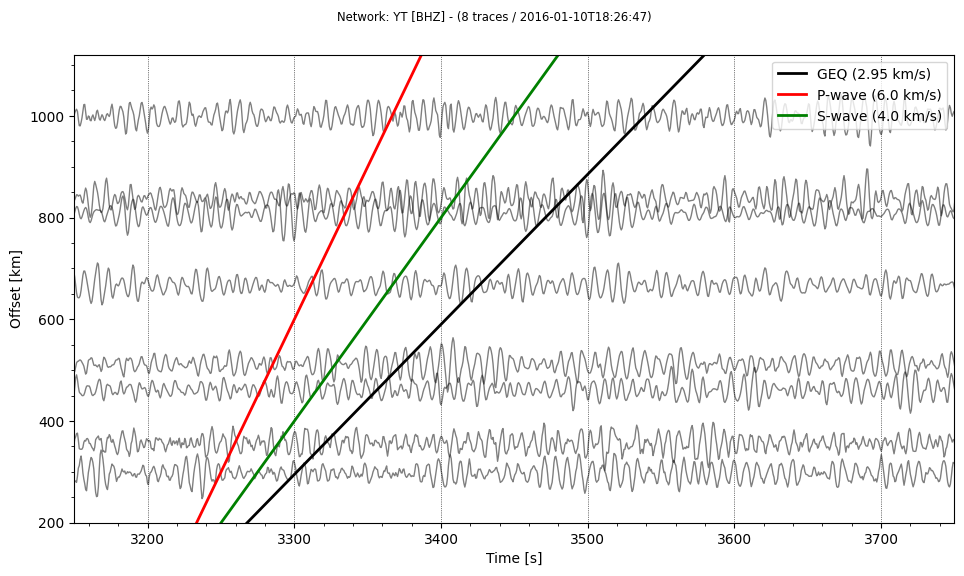

In [25]:
# Plot section and get the figure
fig = signals_filt.select(component='Z').plot(type='section', orientation='horizontal', show=False)

# Get the correct axes
ax = fig.axes[0]

# Get event time as matplotlib date
event_time_dt = obspy.UTCDateTime(event_time).datetime
event_time_num = mdates.date2num(event_time_dt)


secs_offset = [240,          0,     50,    60,      160,      10,    100,    160]
cols_offset = ['black', 'blue', 'red', 'purple', 'orange', 'pink', 'green', 'cyan']

# # Overlay the second set of traces (e.g., signals_geq_filt)
# for i, tr in enumerate(signals_geq_filt.select(component='Z')):
#     # Calculate time axis in seconds since event
#     t = tr.times()
#     # Calculate distance in km
#     y = tr.stats.distance / 1000
#     # Offset for plotting (match ObsPy's section plot style)
#     ax.plot(t+secs_offset[i], np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 55, color='blue', alpha=0.7)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3200 # event time relative to start of BYRD
t_p = y / 6.0 + 3200
t_s = y / 4.0 + 3200
# Plot the red line on the same axes
ax.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax.plot(t_s, y, 'g-', lw=2, label='S-wave (4.0 km/s)')

ax.set_ylim(200, 1120)
ax.set_xlim(3150, 3750)


ax.legend()

# Instead of plt.show(), display the figure directly in Jupyter:
fig.canvas.draw()
fig

In [26]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(12, 6))
# gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])
# ax_left = fig.add_subplot(gs[:, 0])

# for tr in signals_filt.select(component='Z'):
#     t = tr.times()
#     y = tr.stats.distance / 1000
#     ax_left.plot(t, tr.data / np.max(np.abs(tr.data)) * 50 + y, alpha=0.7)

# ax_left.set_title('Section Plot (manual)')
# ax_left.set_xlabel('Time (s)')
# ax_left.set_ylabel('Distance (km)')

# plt.tight_layout()
# plt.show()

C:\Users\thele\AppData\Local\Temp\ipykernel_27964\93619241.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


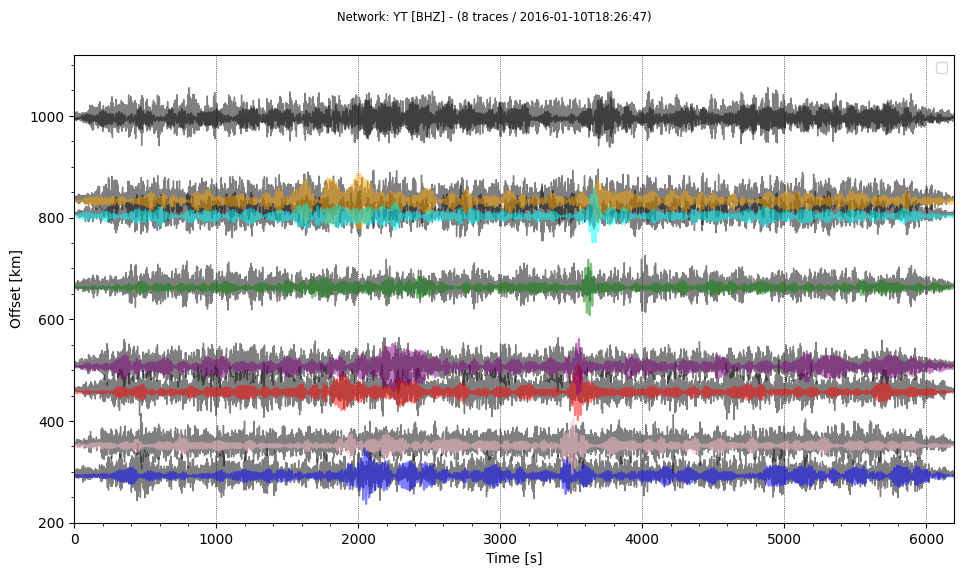

In [27]:
# Plot section and get the figure
fig = signals_filt.select(component='Z').plot(type='section', orientation='horizontal', show=False)

# Get the correct axes
ax = fig.axes[0]

# Get event time as matplotlib date
event_time_dt = obspy.UTCDateTime(event_time).datetime
event_time_num = mdates.date2num(event_time_dt)


secs_offset = [240,          0,     50,    60,      160,      10,    100,    160]
cols_offset = ['black', 'blue', 'red', 'purple', 'orange', 'pink', 'green', 'cyan']

# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    # Calculate time axis in seconds since event
    t = tr.times()
    # Calculate distance in km
    y = tr.stats.distance / 1000
    # Offset for plotting (match ObsPy's section plot style)
    ax.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 55, color=cols_offset[i], alpha=0.5)

# for i, tr in enumerate(signals_filt.select(component='Z')):
#     # Calculate time axis in seconds since event
#     t = tr.times()
#     # Calculate distance in km
#     y = tr.stats.distance / 1000
#     # Offset for plotting (match ObsPy's section plot style)
#     ax.plot(t+secs_offset[i], np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 55, color=cols_offset[i], alpha=0.7)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt.select(component='Z')]) / 1000  # km

# # Generate points for the line
# y = np.linspace(0, 1120, 1000)
# t = y / 2.95 + 3200 # event time relative to start of BYRD
# t_p = y / 6.0 + 3200
# t_s = y / 4.0 + 3200
# # Plot the red line on the same axes
# ax.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
# ax.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
# ax.plot(t_s, y, 'g-', lw=2, label='S-wave (4.0 km/s)')

ax.set_ylim(200, 1120)
#ax.set_xlim(2500, 4000)


ax.legend()

# Instead of plt.show(), display the figure directly in Jupyter:
fig.canvas.draw()
fig

In [28]:
event_time

'2016-01-10T19:23:27.000000Z'

In [29]:
signals_filt

8 Trace(s) in Stream:
XH.RS14..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 20.0 Hz, 124001 samples
YT.BEAR..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.HOWD..BHZ | 2016-01-10T18:26:47.024998Z - 2016-01-10T20:10:06.999998Z | 40.0 Hz, 248000 samples
YT.KOLR..BHZ | 2016-01-10T18:26:47.024998Z - 2016-01-10T20:10:06.999998Z | 40.0 Hz, 248000 samples
YT.MECK..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.THUR..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.UNGL..BHZ | 2016-01-10T18:26:47.000000Z - 2016-01-10T20:10:07.000000Z | 40.0 Hz, 248001 samples
YT.WHIT..BHZ | 2016-01-10T18:26:47.024998Z - 2016-01-10T20:10:06.999998Z | 40.0 Hz, 248000 samples

In [30]:
signals_filt[0].stats.starttime - obspy.UTCDateTime(event_time)

-3400.0

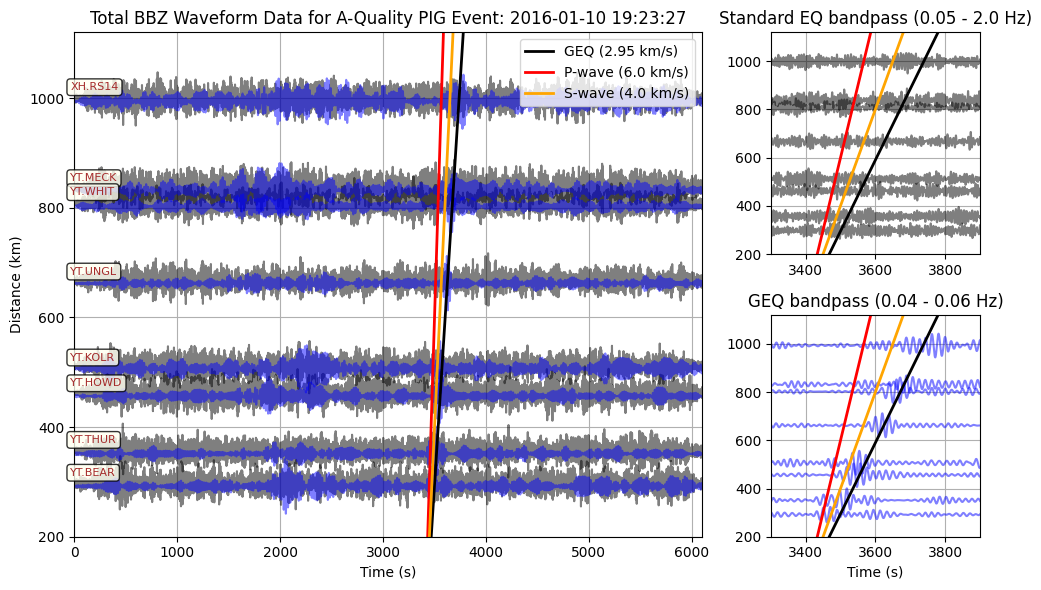

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])

# Left subplot (spans both rows)
ax_left = fig.add_subplot(gs[:, 0])
ax_left.grid(True)
ax_left.set_title('Total BBZ Waveform Data for A-Quality PIG Event: 2016-01-10 19:23:27')

cols_offset = ['black', 'blue', 'red', 'purple', 'orange', 'pink', 'green', 'cyan']
text_offset = [-150,     -150,    -150,    -130,     -150,    -150,   -150,    -150 ]

props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_left.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    Z_left = ax_left.get_xlim()[0] + 270 #+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_left.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_left.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD (3260)
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
# Plot the red line on the same axes
ax_left.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_left.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_left.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')

ax_left.set_ylim(200, 1120)
ax_left.set_ylabel('Distance (km)')
ax_left.set_xlabel('Time (s)')
ax_left.set_xlim(0, 6100)
ax_left.legend(loc='upper right')


# Top right subplot
ax_topright = fig.add_subplot(gs[0, 1])
ax_topright.grid(True)
ax_topright.set_title('Standard EQ bandpass (0.05 - 2.0 Hz)')

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_topright.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_topright.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_topright.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_topright.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_topright.set_ylim(200, 1120)
ax_topright.set_xlim(3300, 3900)

# Bottom right subplot
ax_bottomright = fig.add_subplot(gs[1, 1])
ax_bottomright.grid(True)
ax_bottomright.set_title('GEQ bandpass (0.04 - 0.06 Hz)')

for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_bottomright.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_bottomright.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_bottomright.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_bottomright.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_bottomright.set_ylim(200, 1120)
ax_bottomright.set_xlim(3300, 3900)
ax_bottomright.set_xlabel('Time (s)')


plt.tight_layout()
plt.show()

In [32]:
# setting up the station inventory
inv = ap.get_stations(network='S1', station="AUANU,AUUHS,AUDCS,AUPHS,AUTKS,AUKHS", level='response', channel='BHZ,BHN,BHE', 
                      starttime=obspy.UTCDateTime(2024,1,1,1),
                      endtime = obspy.UTCDateTime(2025,9,1,1))
print(inv)

sta_lats = []
sta_lons = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        sta_lats.append(inv[i][j].latitude)
        sta_lons.append(inv[i][j].longitude)

print('Number of stations:', len(sta_lats))

# indexing the stations to a single variable

stations_flat = []
networks_flat = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        stations_flat.append(inv[i][j].code)
        networks_flat.append(inv[i].code)

print((stations_flat))
print(len(networks_flat))

bulk_stations = []

for i in range(len(sta_lats)):
    receiver_lat = sta_lats[i]
    receiver_lon = sta_lons[i]
    station_code = stations_flat[i]
    bulk_stations.append({"latitude": receiver_lat, "longitude": receiver_lon, "stationcode": station_code})

Inventory created at 2025-10-19T19:02:43.848500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2024-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			S1
		Stations (6):
			S1.AUANU (Australian National University)
			S1.AUDCS (Dubbo College Senior Campus)
			S1.AUKHS (Kincumber High School)
			S1.AUPHS (Peel High School)
			S1.AUTKS (The King's School)
			S1.AUUHS (Ulladulla High School)
		Channels (18):
			S1.AUANU..BHZ, S1.AUANU..BHN, S1.AUANU..BHE, S1.AUDCS..BHZ, 
			S1.AUDCS..BHN, S1.AUDCS..BHE, S1.AUKHS..BHZ, S1.AUKHS..BHN, 
			S1.AUKHS..BHE, S1.AUPHS..BHZ, S1.AUPHS..BHN, S1.AUPHS..BHE, 
			S1.AUTKS..BHZ, S1.AUTKS..BHN, S1.AUTKS..BHE, S1.AUUHS..BHZ, 
			S1.AUUHS..BHN, S1.AUUHS..BHE
Number of stations: 6
['AUANU', 'AUDCS', 'AUKHS', 'AUPHS', 'AUTKS', 'AUUHS']
6


In [33]:
signals2 = Stream()
signals2.clear()

dist_infos2, back_azs2, begin_times2, end_times2, arrival_times2 = [], [], [], [], []

for i in range(len(bulk_stations)):
    dist_info = distance(-32.70, 151.06, bulk_stations[i]['latitude'], bulk_stations[i]['longitude']) / 1e3
    if dist_info < 1000:  # Only consider stations within 1000 km
        back_az = back_azimuth(-32.70, 151.06, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])
        try:
            time_to_arrive = dist_info / 2.95  # assuming average speed of 2.95 km/s
            begin_time = obspy.UTCDateTime(2025, 4, 22, 16, 55, 0) - 210 #+ time_to_arrive - 60*60
            end_time = obspy.UTCDateTime(2025, 4, 22, 17, 0, 0) + 210 #+ time_to_arrive + 50*60
            st = ap.get_waveforms(network=networks_flat[i], station=stations_flat[i], channel='BHZ', location='*', starttime=begin_time, endtime=end_time)
            st.remove_response(inv,output='DISP',taper=True, taper_fraction=0.1)
            st.detrend('linear')
            st.detrend('demean')
            st.taper(max_percentage=0.1) # original 0.1
            #st.rotate('NE->RT', back_az)
            for tr in st:
                tr.stats.distance = dist_info*1000  # in meters
                if not hasattr(tr.stats, "coordinates"):
                    tr.stats.coordinates = {}
                tr.stats.coordinates["latitude"] = bulk_stations[i]['latitude']
                tr.stats.coordinates["longitude"] = bulk_stations[i]['longitude']
            signals2 += st
            dist_infos2.append(dist_info)
            back_azs2.append(back_az)
            begin_times2.append(begin_time)
            end_times2.append(end_time)
            arrival_times2.append(obspy.UTCDateTime(event_time) + time_to_arrive)
            print(f"Got data for station {bulk_stations[i]['stationcode']}")
        except Exception as e:
            print(f"Could not get data for station {bulk_stations[i]['stationcode']}: {e}")

Got data for station AUANU
Got data for station AUDCS
Got data for station AUKHS
Got data for station AUPHS
Got data for station AUTKS
Got data for station AUUHS


In [34]:
# Create a new Stream to store merged traces
merged_signals = Stream()

# Get unique station codes
stations = list(set(tr.stats.station for tr in signals2))

desired_npts = 62000  # Set desired number of samples

# For each unique station
for station in stations:
    # Get all traces for this station
    station_traces = signals2.select(station=station)
    
    if len(station_traces) > 1:
        # Find earliest start and latest end time
        start_time = min(tr.stats.starttime for tr in station_traces)
        end_time = max(tr.stats.endtime for tr in station_traces)
        
        # Create zero-filled array
        merged_data = np.zeros(desired_npts)
        
        # Calculate time per sample for the desired length
        dt = (end_time - start_time) / desired_npts
        
        # Fill in data from each trace
        for tr in station_traces:
            # Calculate position in samples
            start_idx = int(np.round((tr.stats.starttime - start_time) / dt))
            
            # Resample trace data to fit required spacing
            npts_current = int(np.round(len(tr.data) * dt / tr.stats.delta))
            resampled_data = np.interp(
                np.linspace(0, len(tr.data)-1, npts_current),
                np.arange(len(tr.data)),
                tr.data
            )
            
            # Ensure we don't exceed array bounds
            end_idx = min(start_idx + len(resampled_data), desired_npts)
            data_to_use = resampled_data[:end_idx-start_idx]
            
            # Add data to merged array
            merged_data[start_idx:end_idx] = data_to_use
        
        # Create new trace with merged data
        new_trace = station_traces[0].copy()
        new_trace.data = merged_data
        new_trace.stats.starttime = start_time
        new_trace.stats.npts = desired_npts
        new_trace.stats.delta = (end_time - start_time) / desired_npts
        
        merged_signals += new_trace
    else:
        # If only one trace exists, resample to desired length
        tr = station_traces[0]
        resampled_data = np.interp(
            np.linspace(0, len(tr.data)-1, desired_npts),
            np.arange(len(tr.data)),
            tr.data
        )
        new_trace = tr.copy()
        new_trace.data = resampled_data
        new_trace.stats.npts = desired_npts
        new_trace.stats.delta = (tr.stats.endtime - tr.stats.starttime) / desired_npts
        
        merged_signals += new_trace

print("Merged signals:")
print(merged_signals)

Merged signals:
6 Trace(s) in Stream:
S1.AUKHS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:29.988387Z | 86.1 Hz, 62000 samples
S1.AUTKS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:29.988387Z | 86.1 Hz, 62000 samples
S1.AUUHS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:29.988387Z | 86.1 Hz, 62000 samples
S1.AUDCS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:29.988387Z | 86.1 Hz, 62000 samples
S1.AUPHS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:29.988387Z | 86.1 Hz, 62000 samples
S1.AUANU..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:29.988387Z | 86.1 Hz, 62000 samples


In [35]:
signals_filt2 = merged_signals.copy()

for tr in signals_filt2:
    tr.filter('bandpass', freqmin=0.05, freqmax=20, corners=3, zerophase=True)
    tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)

signals_geq_filt2 = merged_signals.copy()

for tr in signals_geq_filt2:
    tr.filter('bandpass', freqmin=0.04, freqmax=0.06, corners=3, zerophase=True)
    tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)


In [36]:
signals2

10 Trace(s) in Stream:
S1.AUANU..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:30.000000Z | 10.0 Hz, 7201 samples
S1.AUDCS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:00:50.900000Z | 10.0 Hz, 5610 samples
S1.AUDCS..BHZ | 2025-04-22T17:01:41.000000Z - 2025-04-22T17:03:30.000000Z | 10.0 Hz, 1091 samples
S1.AUKHS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:01:02.900000Z | 10.0 Hz, 5730 samples
S1.AUKHS..BHZ | 2025-04-22T17:01:53.000000Z - 2025-04-22T17:03:30.000000Z | 10.0 Hz, 971 samples
S1.AUPHS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:00:45.900000Z | 10.0 Hz, 5560 samples
S1.AUPHS..BHZ | 2025-04-22T17:02:26.000000Z - 2025-04-22T17:03:30.000000Z | 10.0 Hz, 641 samples
S1.AUTKS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:30.000000Z | 10.0 Hz, 7201 samples
S1.AUUHS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:00:39.900000Z | 10.0 Hz, 5500 samples
S1.AUUHS..BHZ | 2025-04-22T17:02:20.000000Z - 2025-04-22T17:03:30.000000Z | 10.0 Hz, 701 samples

In [37]:
signals2long = Stream()
signals2long.clear()

dist_infos2, back_azs2, begin_times2, end_times2, arrival_times2 = [], [], [], [], []

for i in range(len(bulk_stations)):
    dist_info = distance(-32.70, 151.06, bulk_stations[i]['latitude'], bulk_stations[i]['longitude']) / 1e3
    if dist_info < 1000:  # Only consider stations within 1000 km
        back_az = back_azimuth(-32.70, 151.06, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])
        try:
            time_to_arrive = dist_info / 2.95  # assuming average speed of 2.95 km/s
            begin_time = obspy.UTCDateTime(2025, 4, 22, 16, 55, 0) - 60*60 + 200
            end_time = obspy.UTCDateTime(2025, 4, 22, 16, 55, 0) + 50*60
            st = ap.get_waveforms(network=networks_flat[i], station=stations_flat[i], channel='BHZ', location='*', starttime=begin_time, endtime=end_time)
            st.remove_response(inv,output='DISP',taper=True, taper_fraction=0.1)
            st.detrend('linear')
            st.detrend('demean')
            st.taper(max_percentage=0.1) # original 0.1
            #st.rotate('NE->RT', back_az)
            for tr in st:
                tr.stats.distance = dist_info*1000  # in meters
                if not hasattr(tr.stats, "coordinates"):
                    tr.stats.coordinates = {}
                tr.stats.coordinates["latitude"] = bulk_stations[i]['latitude']
                tr.stats.coordinates["longitude"] = bulk_stations[i]['longitude']
            signals2long += st
            dist_infos2.append(dist_info)
            back_azs2.append(back_az)
            begin_times2.append(begin_time)
            end_times2.append(end_time)
            arrival_times2.append(obspy.UTCDateTime(event_time) + time_to_arrive)
            print(f"Got data for station {bulk_stations[i]['stationcode']}")
        except Exception as e:
            print(f"Could not get data for station {bulk_stations[i]['stationcode']}: {e}")

Got data for station AUANU
Got data for station AUDCS
Got data for station AUKHS
Got data for station AUPHS
Got data for station AUTKS
Got data for station AUUHS


In [38]:
signals_filt2 = signals2long.copy()

for tr in signals_filt2:
    tr.filter('bandpass', freqmin=0.05, freqmax=2, corners=3, zerophase=True)
    # tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)
    
signals_geq_filt2 = signals2long.copy()

for tr in signals_geq_filt2:
    tr.filter('bandpass', freqmin=0.04, freqmax=0.06, corners=3, zerophase=True)
    # tr.trim(starttime=tr.stats.starttime+200, endtime=tr.stats.endtime-200)

In [39]:
signals_filt2

10 Trace(s) in Stream:
S1.AUANU..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 64001 samples
S1.AUDCS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:00:50.900000Z | 10.0 Hz, 37510 samples
S1.AUDCS..BHZ | 2025-04-22T17:01:41.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 25991 samples
S1.AUKHS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:01:02.900000Z | 10.0 Hz, 37630 samples
S1.AUKHS..BHZ | 2025-04-22T17:01:53.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 25871 samples
S1.AUPHS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:00:45.900000Z | 10.0 Hz, 37460 samples
S1.AUPHS..BHZ | 2025-04-22T17:02:26.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 25541 samples
S1.AUTKS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 64001 samples
S1.AUUHS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:00:39.900000Z | 10.0 Hz, 37400 samples
S1.AUUHS..BHZ | 2025-04-22T17:02:20.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 2

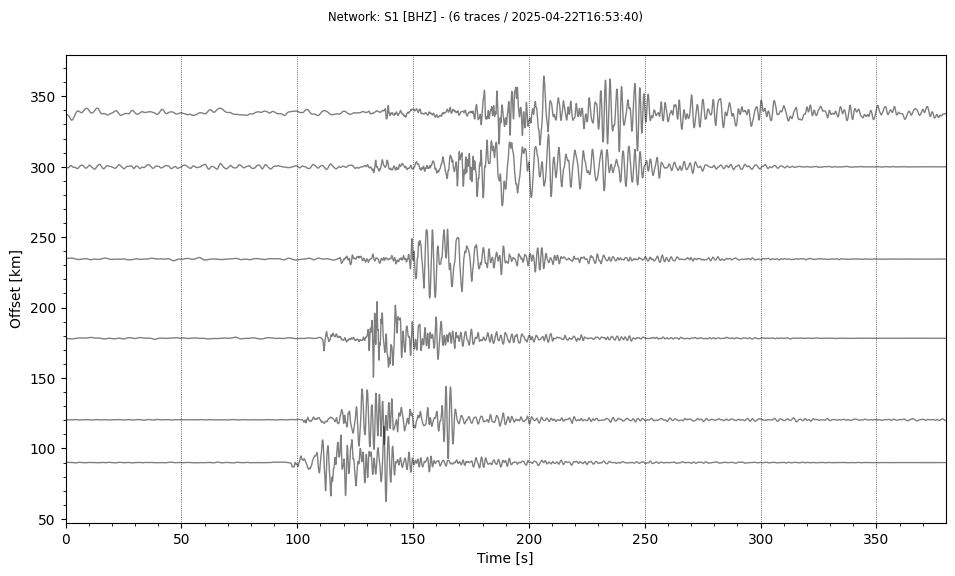

In [40]:
regfilt = signals_filt2.plot(type='section', orientation='horizontal', starttime=obspy.UTCDateTime(2025,4,22,16,53,40), endtime=obspy.UTCDateTime(2025,4,22,17,0,0))

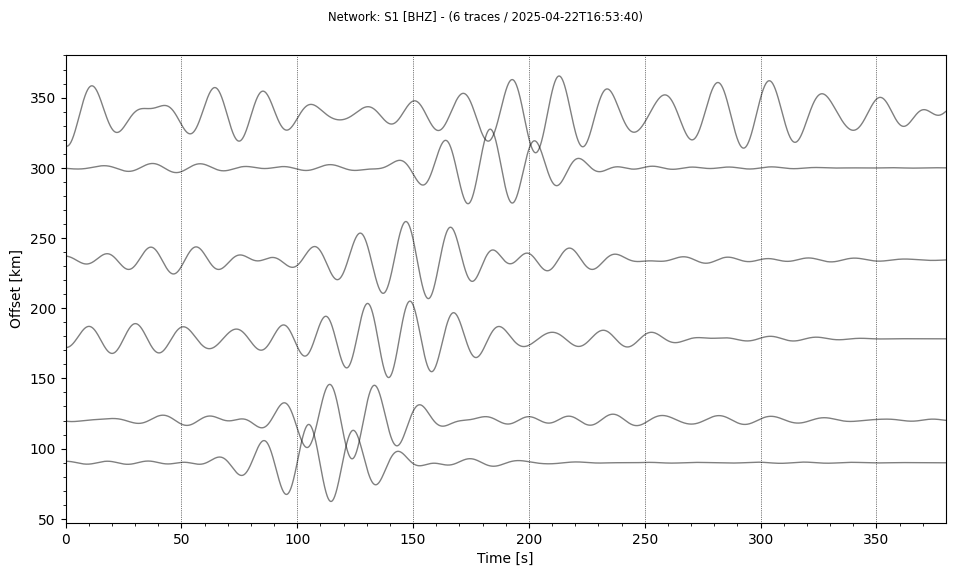

In [41]:
geqfilt = signals_geq_filt2.plot(type='section', orientation='horizontal', starttime=obspy.UTCDateTime(2025,4,22,16,53,40), endtime=obspy.UTCDateTime(2025,4,22,17,0,0))

In [42]:
signals_filt2[0].stats.starttime - obspy.UTCDateTime(2025, 4, 22, 17, 0, 0)

-3700.0

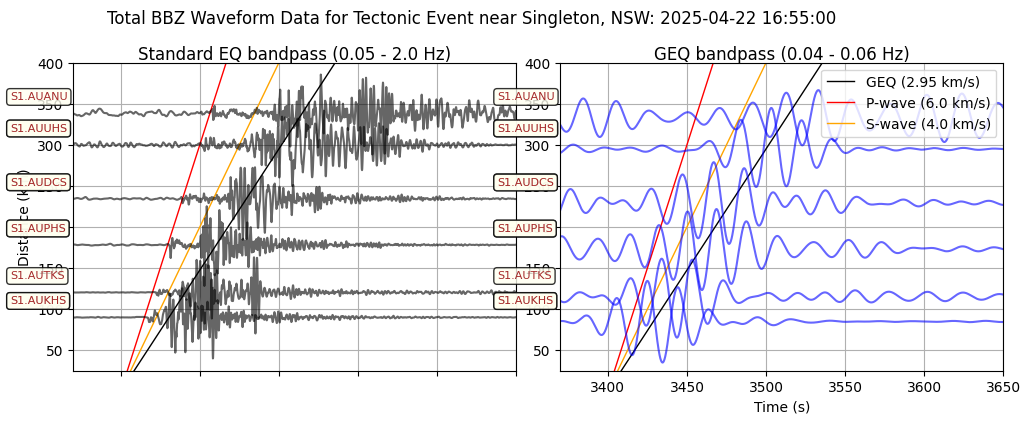

In [43]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

ax_left = fig.add_subplot(gs[0])
ax_left.grid(True)
ax_left.set_title('Total BBZ Waveform Data for Tectonic Event near Singleton, NSW: 2025-04-22 16:55:00', y=1.1, x=0.9)
ax_left.text(0.5, 1.01,'Standard EQ bandpass (0.05 - 2.0 Hz)', transform=ax_left.transAxes, fontsize=12, ha='center')
ax_right = fig.add_subplot(gs[1])
ax_right.grid(True)
ax_right.text(0.5, 1.01,'GEQ bandpass (0.04 - 0.06 Hz)', transform=ax_right.transAxes, fontsize=12, ha='center')

props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt2.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 600, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD (3260)
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
# Plot the red line on the same axes
ax_left.plot(t, y, 'k-', lw=1, label='GEQ (2.95 km/s)')
ax_left.plot(t_p, y, 'r-', lw=1, label='P-wave (6.0 km/s)')
ax_left.plot(t_s, y, c='orange', linestyle='-', lw=1, label='S-wave (4.0 km/s)')

ax_right.plot(t, y, 'k-', lw=1, label='GEQ (2.95 km/s)')
ax_right.plot(t_p, y, 'r-', lw=1, label='P-wave (6.0 km/s)')
ax_right.plot(t_s, y, c='orange', linestyle='-', lw=1, label='S-wave (4.0 km/s)')

for i, tr in enumerate(signals_filt2.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_left.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.6)
    Z_left = ax_left.get_xlim()[0] + 3650#+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_left.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt2.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_right.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.6)
    Z_left = ax_right.get_xlim()[0] + 3650#+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_right.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


ax_left.set_ylim(25, 400)
ax_left.set_ylabel('Distance (km)')
# ax_left.set_xlabel('Time (s)')
ax_left.set_xlim(3370, 3650)
ax_right.legend(loc='upper right')
ax_left.set_xticklabels([])
ax_right.set_ylim(25, 400)
# ax_right.set_ylabel('Distance (km)')
ax_right.set_xlabel('Time (s)')
ax_right.set_xlim(3370, 3650)

plt.show()

C:\Users\thele\AppData\Local\Temp\ipykernel_27964\2135812103.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


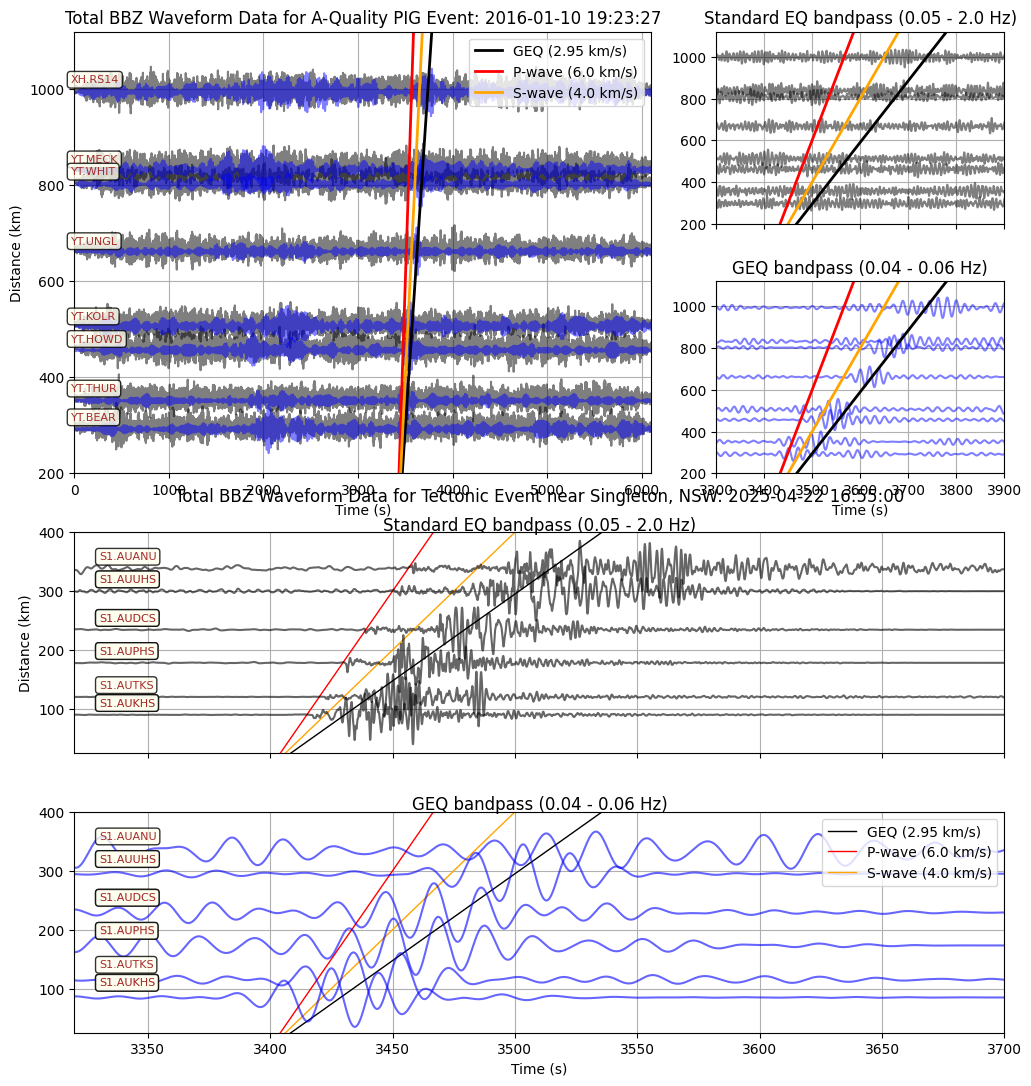

In [44]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(12, 13))

# Create main GridSpec with 3 rows
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.5, 0.5], hspace=0.2, wspace=0.1)

# Create sub-GridSpec for top row
gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[3, 1.5], wspace=0.15)

# Create sub-GridSpec for right panel of top row
gs_top_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_top[1], hspace=0.3)

# Create all axes
ax_top_left = fig.add_subplot(gs_top[0])
ax_top_right_upper = fig.add_subplot(gs_top_right[0])
ax_top_right_lower = fig.add_subplot(gs_top_right[1])
ax_middle = fig.add_subplot(gs[1])
ax_bottom = fig.add_subplot(gs[2])

### GEQ DATA

ax_top_left.set_title('Total BBZ Waveform Data for A-Quality PIG Event: 2016-01-10 19:23:27')

cols_offset = ['black', 'blue', 'red', 'purple', 'orange', 'pink', 'green', 'cyan']
text_offset = [-150,     -150,    -150,    -130,     -150,    -150,   -150,    -150 ]

props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_left.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    Z_left = ax_top_left.get_xlim()[0] + 270 #+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_top_left.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_left.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD (3260)
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
# Plot the red line on the same axes
ax_top_left.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_top_left.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_top_left.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')

ax_top_left.set_ylim(200, 1120)
ax_top_left.set_ylabel('Distance (km)')
ax_top_left.set_xlabel('Time (s)')
ax_top_left.set_xlim(0, 6100)
ax_top_left.legend(loc='upper right')


# Top right subplot
ax_top_right_upper.set_title('Standard EQ bandpass (0.05 - 2.0 Hz)')

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_right_upper.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_top_right_upper.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_top_right_upper.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_top_right_upper.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_top_right_upper.set_ylim(200, 1120)
ax_top_right_upper.set_xlim(3300, 3900)
ax_top_right_upper.set_xticklabels([])

# Bottom right subplot
ax_top_right_lower.set_title('GEQ bandpass (0.04 - 0.06 Hz)')

for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_right_lower.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_top_right_lower.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_top_right_lower.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_top_right_lower.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_top_right_lower.set_ylim(200, 1120)
ax_top_right_lower.set_xlim(3300, 3900)
ax_top_right_lower.set_xlabel('Time (s)')


### Singleton DATA

ax_middle.set_title('Total BBZ Waveform Data for Tectonic Event near Singleton, NSW: 2025-04-22 16:55:00', y=1.1, x=0.5)
ax_middle.text(0.5, 1.01,'Standard EQ bandpass (0.05 - 2.0 Hz)', transform=ax_middle.transAxes, fontsize=12, ha='center')
ax_bottom.text(0.5, 1.01,'GEQ bandpass (0.04 - 0.06 Hz)', transform=ax_bottom.transAxes, fontsize=12, ha='center')

props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt2.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 600, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD (3260)
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
# Plot the red line on the same axes
ax_middle.plot(t, y, 'k-', lw=1, label='GEQ (2.95 km/s)')
ax_middle.plot(t_p, y, 'r-', lw=1, label='P-wave (6.0 km/s)')
ax_middle.plot(t_s, y, c='orange', linestyle='-', lw=1, label='S-wave (4.0 km/s)')

ax_bottom.plot(t, y, 'k-', lw=1, label='GEQ (2.95 km/s)')
ax_bottom.plot(t_p, y, 'r-', lw=1, label='P-wave (6.0 km/s)')
ax_bottom.plot(t_s, y, c='orange', linestyle='-', lw=1, label='S-wave (4.0 km/s)')

for i, tr in enumerate(signals_filt2.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_middle.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.6)
    Z_left = ax_middle.get_xlim()[0] + 3650#+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_middle.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt2.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_bottom.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.6)
    Z_left = ax_bottom.get_xlim()[0] + 3650#+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_bottom.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


ax_middle.set_ylim(25, 400)
ax_middle.set_ylabel('Distance (km)')
# ax_middle.set_xlabel('Time (s)')
ax_middle.set_xlim(3320, 3700)
ax_bottom.legend(loc='upper right')
ax_middle.set_xticklabels([])
ax_bottom.set_ylim(25, 400)
# ax_bottom.set_ylabel('Distance (km)')
ax_bottom.set_xlabel('Time (s)')
ax_bottom.set_xlim(3320, 3700)

# Add gridlines
for ax in [ax_top_left, ax_top_right_upper, ax_top_right_lower, ax_middle, ax_bottom]:
    ax.grid(True)

plt.tight_layout()
plt.show()

C:\Users\thele\AppData\Local\Temp\ipykernel_27964\1541067012.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


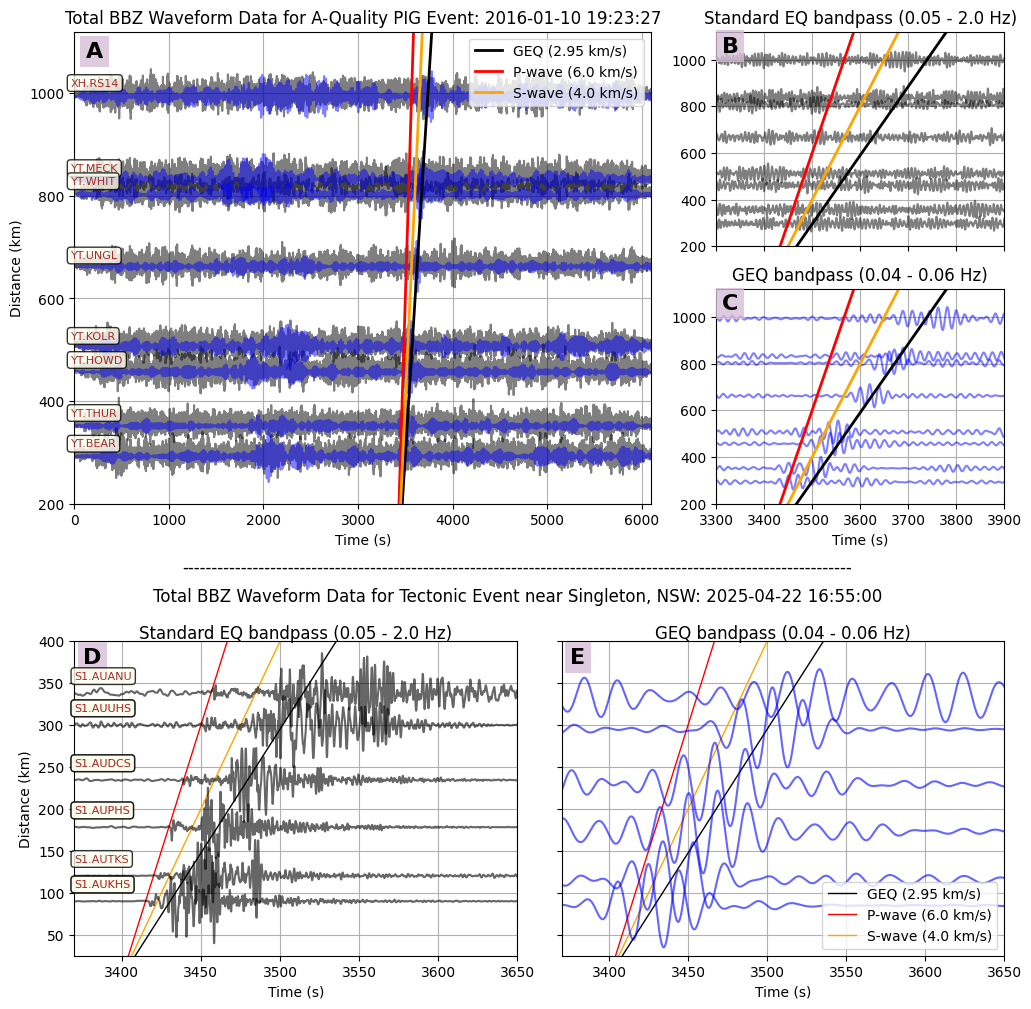

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(12, 12))

# Create main GridSpec with 2 rows
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1], hspace=0.35)

# Create sub-GridSpec for top row
gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[3, 1.5], wspace=0.15)

# Create sub-GridSpec for right panel of top row
gs_top_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_top[1], hspace=0.2)

# Create sub-GridSpec for bottom row
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], wspace=0.1)

# Create all axes
ax_top_left = fig.add_subplot(gs_top[0])
ax_top_right_upper = fig.add_subplot(gs_top_right[0])
ax_top_right_lower = fig.add_subplot(gs_top_right[1])
ax_bottom_left = fig.add_subplot(gs_bottom[0])
ax_bottom_right = fig.add_subplot(gs_bottom[1])

# After creating all the axes but before adding any data, add these labels:
ax_top_left.text(0.02, 0.98, 'A', transform=ax_top_left.transAxes, 
                 fontsize=16, fontweight='bold', va='top',
                 bbox=dict(facecolor='thistle', edgecolor='none', alpha=0.8))
ax_top_right_upper.text(0.02, 0.98, 'B', transform=ax_top_right_upper.transAxes, 
                        fontsize=16, fontweight='bold', va='top',
                        bbox=dict(facecolor='thistle', edgecolor='none', alpha=0.8))
ax_top_right_lower.text(0.02, 0.98, 'C', transform=ax_top_right_lower.transAxes, 
                        fontsize=16, fontweight='bold', va='top',
                        bbox=dict(facecolor='thistle', edgecolor='none', alpha=0.8))
ax_bottom_left.text(0.02, 0.98, 'D', transform=ax_bottom_left.transAxes, 
                    fontsize=16, fontweight='bold', va='top',
                    bbox=dict(facecolor='thistle', edgecolor='none', alpha=0.8))
ax_bottom_right.text(0.02, 0.98, 'E', transform=ax_bottom_right.transAxes, 
                     fontsize=16, fontweight='bold', va='top',
                     bbox=dict(facecolor='thistle', edgecolor='none', alpha=0.8))


### GEQ DATA

ax_top_left.set_title('Total BBZ Waveform Data for A-Quality PIG Event: 2016-01-10 19:23:27')

cols_offset = ['black', 'blue', 'red', 'purple', 'orange', 'pink', 'green', 'cyan']
text_offset = [-150,     -150,    -150,    -130,     -150,    -150,   -150,    -150 ]

props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_left.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    Z_left = ax_top_left.get_xlim()[0] + 270 #+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_top_left.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_left.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD (3260)
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
# Plot the red line on the same axes
ax_top_left.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_top_left.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_top_left.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')

ax_top_left.set_ylim(200, 1120)
ax_top_left.set_ylabel('Distance (km)')
ax_top_left.set_xlabel('Time (s)')
ax_top_left.set_xlim(0, 6100)
ax_top_left.legend(loc='upper right')


# Top right subplot
ax_top_right_upper.set_title('Standard EQ bandpass (0.05 - 2.0 Hz)')

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_right_upper.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_top_right_upper.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_top_right_upper.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_top_right_upper.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_top_right_upper.set_ylim(200, 1120)
ax_top_right_upper.set_xlim(3300, 3900)
ax_top_right_upper.set_xticklabels([])

# Bottom right subplot
ax_top_right_lower.set_title('GEQ bandpass (0.04 - 0.06 Hz)')

for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_top_right_lower.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_top_right_lower.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_top_right_lower.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_top_right_lower.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_top_right_lower.set_ylim(200, 1120)
ax_top_right_lower.set_xlim(3300, 3900)
ax_top_right_lower.set_xlabel('Time (s)')


### Singleton DATA
ax_bottom_left.text(1.0, 1.22, '------------------------------------------------------------------------------------------------------------------', transform=ax_bottom_left.transAxes, fontsize=12, ha='center')
ax_bottom_left.set_title('Total BBZ Waveform Data for Tectonic Event near Singleton, NSW: 2025-04-22 16:55:00', y=1.1, x=1)
ax_bottom_left.text(0.5, 1.01,'Standard EQ bandpass (0.05 - 2.0 Hz)', transform=ax_bottom_left.transAxes, fontsize=12, ha='center')
ax_bottom_right.text(0.5, 1.01,'GEQ bandpass (0.04 - 0.06 Hz)', transform=ax_bottom_right.transAxes, fontsize=12, ha='center')

props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt2.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 600, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD (3260)
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
# Plot the red line on the same axes
ax_bottom_left.plot(t, y, 'k-', lw=1, label='GEQ (2.95 km/s)')
ax_bottom_left.plot(t_p, y, 'r-', lw=1, label='P-wave (6.0 km/s)')
ax_bottom_left.plot(t_s, y, c='orange', linestyle='-', lw=1, label='S-wave (4.0 km/s)')

ax_bottom_right.plot(t, y, 'k-', lw=1, label='GEQ (2.95 km/s)')
ax_bottom_right.plot(t_p, y, 'r-', lw=1, label='P-wave (6.0 km/s)')
ax_bottom_right.plot(t_s, y, c='orange', linestyle='-', lw=1, label='S-wave (4.0 km/s)')

for i, tr in enumerate(signals_filt2.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_bottom_left.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.6)
    Z_left = ax_bottom_left.get_xlim()[0] + 3690#+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_bottom_left.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt2.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_bottom_right.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.6)
    Z_left = ax_bottom_right.get_xlim()[0] + 3650#+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]

ax_bottom_left.set_ylim(25, 400)
ax_bottom_left.set_xlabel('Time (s)')
# ax_bottom_left.set_xlabel('Time (s)')
ax_bottom_left.set_xlim(3370, 3650)
ax_bottom_right.legend(loc='lower right')
ax_bottom_right.set_yticklabels([])
ax_bottom_right.set_ylim(25, 400)
ax_bottom_left.set_ylabel('Distance (km)')
ax_bottom_right.set_xlabel('Time (s)')
ax_bottom_right.set_xlim(3370, 3650)

# Add gridlines
for ax in [ax_top_left, ax_top_right_upper, ax_top_right_lower, ax_bottom_left, ax_bottom_right]:
    ax.grid(True)

plt.tight_layout()

fig.savefig('wave_arrivals.png', bbox_inches='tight', dpi=300)

plt.show()

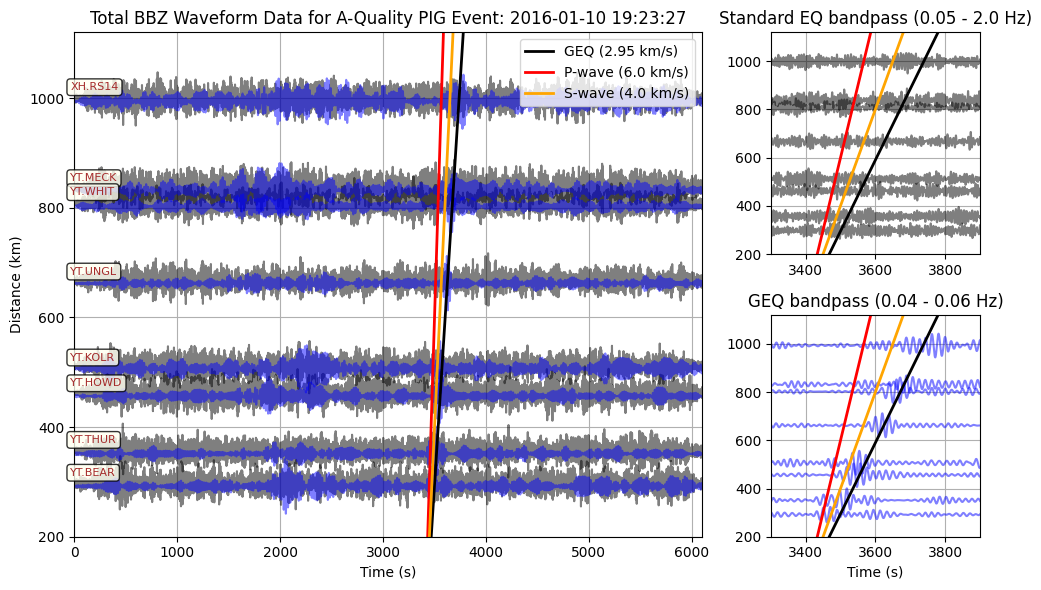

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])

# Left subplot (spans both rows)
ax_left = fig.add_subplot(gs[:, 0])
ax_left.grid(True)
ax_left.set_title('Total BBZ Waveform Data for A-Quality PIG Event: 2016-01-10 19:23:27')

cols_offset = ['black', 'blue', 'red', 'purple', 'orange', 'pink', 'green', 'cyan']
text_offset = [-150,     -150,    -150,    -130,     -150,    -150,   -150,    -150 ]

props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_left.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    Z_left = ax_left.get_xlim()[0] + 270 #+ text_offset[i]
    Z_start = (np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50)[0]
    ax_left.text(Z_left, Z_start+20, s=f'{tr.stats.network}.{tr.stats.station}', color='brown', fontsize=8, ha='left', va='center', bbox=props)


# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_left.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt.select(component='Z')]) / 1000  # km

# Generate points for the line
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD (3260)
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
# Plot the red line on the same axes
ax_left.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_left.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_left.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')

ax_left.set_ylim(200, 1120)
ax_left.set_ylabel('Distance (km)')
ax_left.set_xlabel('Time (s)')
ax_left.set_xlim(0, 6100)
ax_left.legend(loc='upper right')


# Top right subplot
ax_topright = fig.add_subplot(gs[0, 1])
ax_topright.grid(True)
ax_topright.set_title('Standard EQ bandpass (0.05 - 2.0 Hz)')

for i, tr in enumerate(signals_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_topright.plot(t, np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 50, color='k', alpha=0.5)
    
y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_topright.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_topright.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_topright.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_topright.set_ylim(200, 1120)
ax_topright.set_xlim(3300, 3900)

# Bottom right subplot
ax_bottomright = fig.add_subplot(gs[1, 1])
ax_bottomright.grid(True)
ax_bottomright.set_title('GEQ bandpass (0.04 - 0.06 Hz)')

for i, tr in enumerate(signals_geq_filt.select(component='Z')):
    t = tr.times()
    y = tr.stats.distance / 1000
    ax_bottomright.plot(t, np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 50, color='blue', alpha=0.5)

y = np.linspace(0, 1120, 1000)
t = y / 2.95 + 3400 # event time relative to start of BYRD
t_p = y / 6.0 + 3400
t_s = y / 4.0 + 3400
ax_bottomright.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
ax_bottomright.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
ax_bottomright.plot(t_s, y, c='orange', linestyle='-', lw=2, label='S-wave (4.0 km/s)')
ax_bottomright.set_ylim(200, 1120)
ax_bottomright.set_xlim(3300, 3900)
ax_bottomright.set_xlabel('Time (s)')


plt.tight_layout()
plt.show()

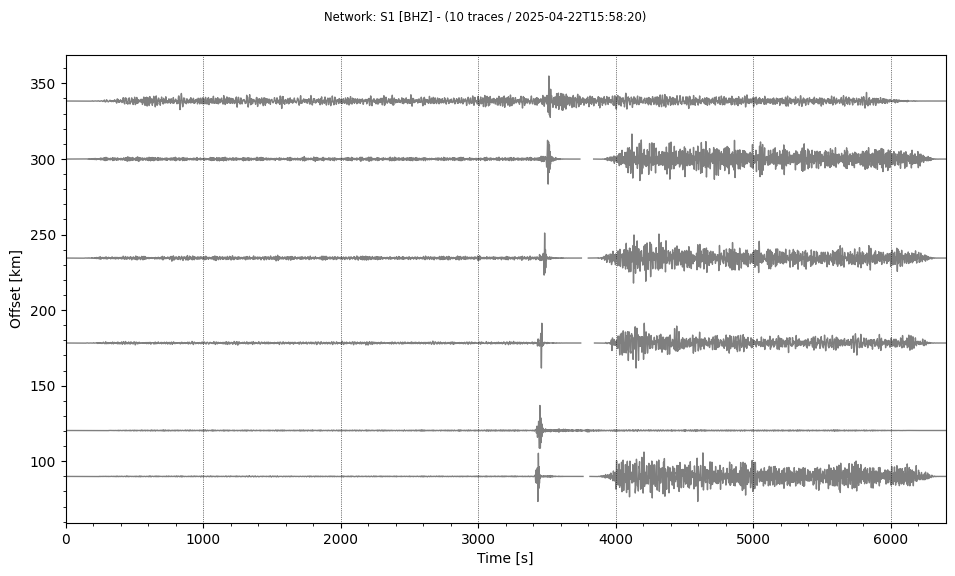

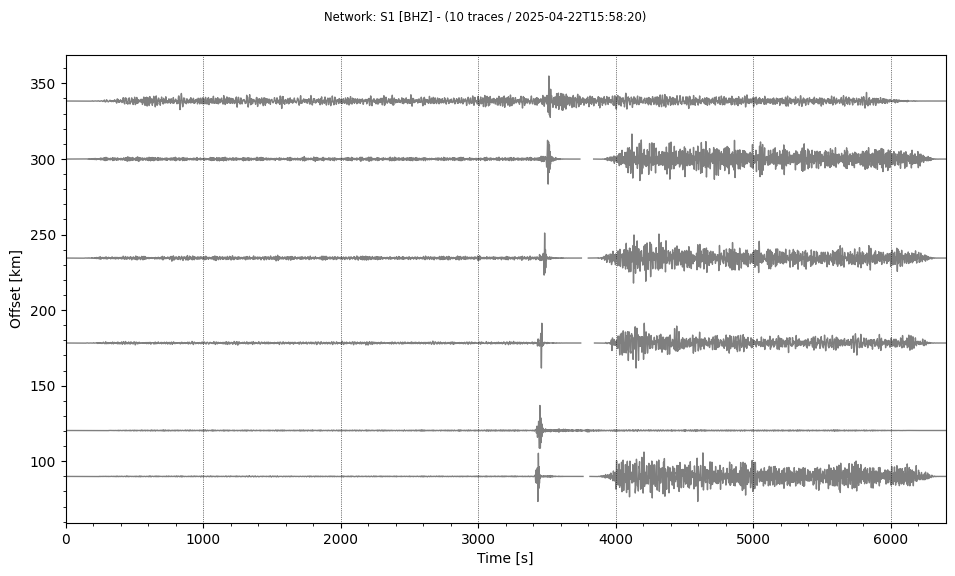

In [47]:
signana3 = signals2long.copy()
for tr in signana3:
    tr.filter('bandpass', freqmin=0.05, freqmax=0.2, corners=3, zerophase=True) # test_sig.filter('bandpass', freqmin=0.05, freqmax=2, corners=3, zerophase=True)
    # tr.trim(starttime=obspy.UTCDateTime(2025, 4, 22, 16, 55, 0, 0), endtime=obspy.UTCDateTime(2025, 4, 22, 17, 0, 0, 0))
    tr.taper(max_percentage=0.1) # original 0.1
    
signana3.plot(type='section', orientation='horizontal')

In [48]:
signana2 = signals2.copy()
for tr in signana2:
    tr.filter('bandpass', freqmin=0.05, freqmax=2, corners=3, zerophase=True) # test_sig.filter('bandpass', freqmin=0.05, freqmax=2, corners=3, zerophase=True)
    tr.trim(starttime=obspy.UTCDateTime(2025, 4, 22, 16, 55, 0, 0), endtime=obspy.UTCDateTime(2025, 4, 22, 17, 0, 0, 0))
    tr.taper(max_percentage=0.1) # original 0.1

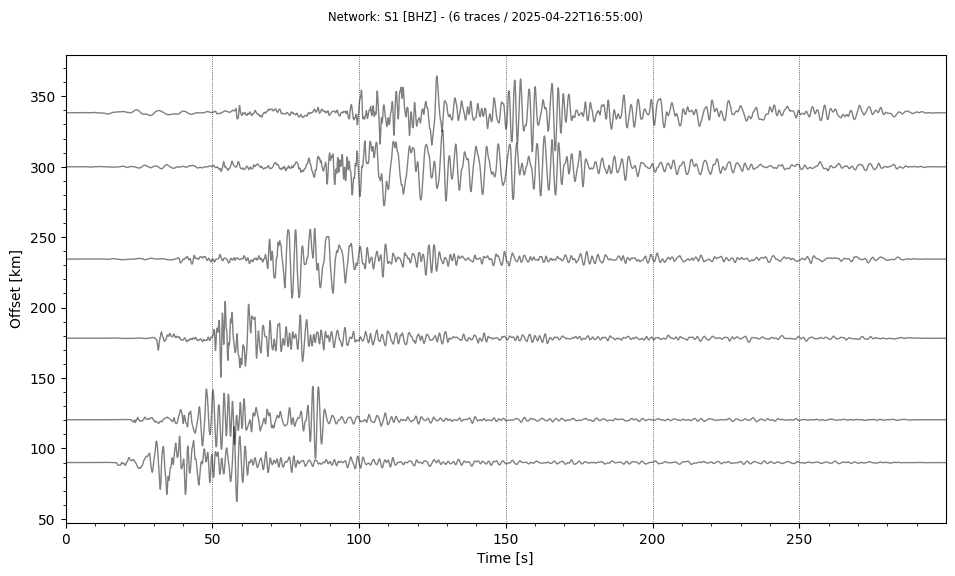

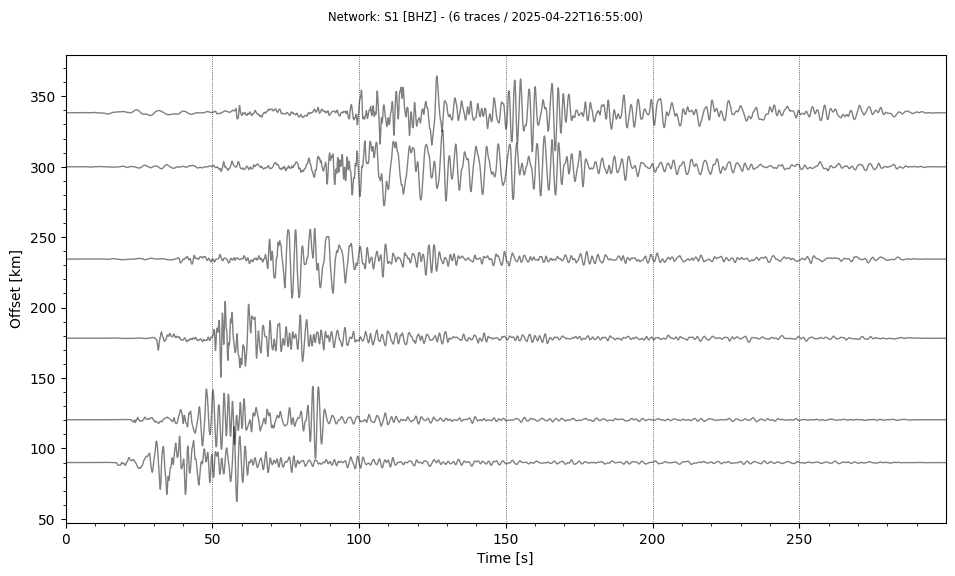

In [49]:
signana2.plot(type='section', orientation='horizontal')

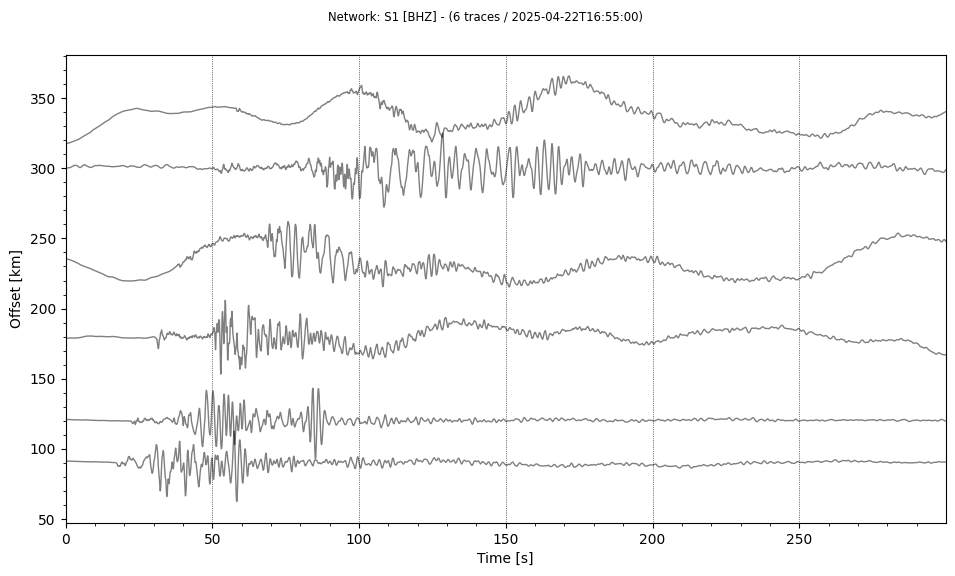

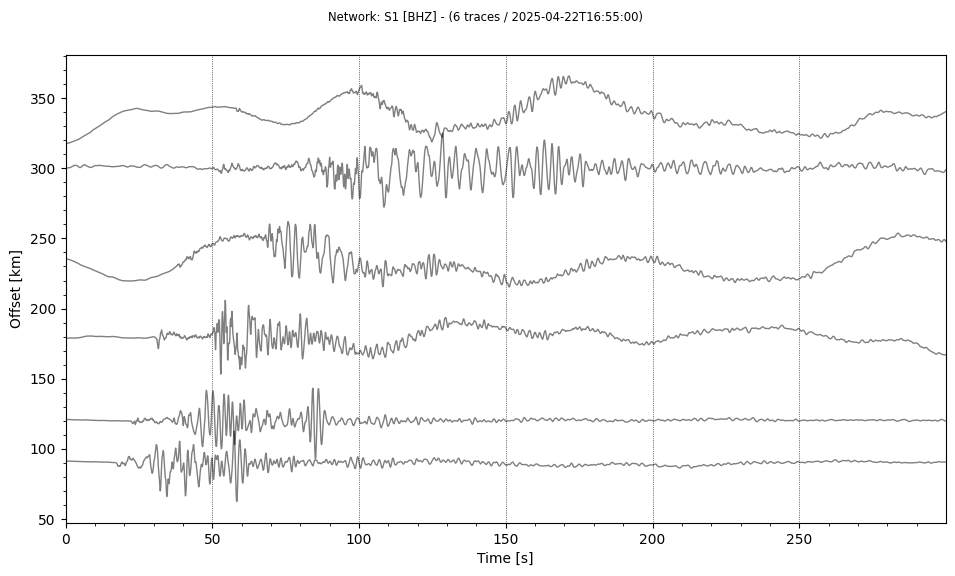

In [50]:
signals2.select(component='Z').plot(type='section', orientation='horizontal', starttime=obspy.UTCDateTime(2025,4,22,16,55,0), endtime=obspy.UTCDateTime(2025,4,22,17,0,0))

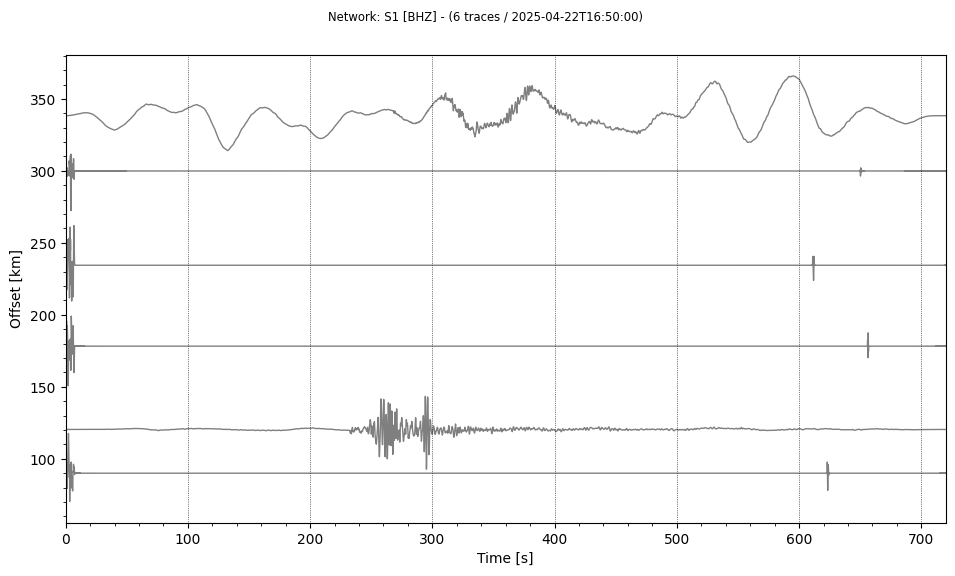

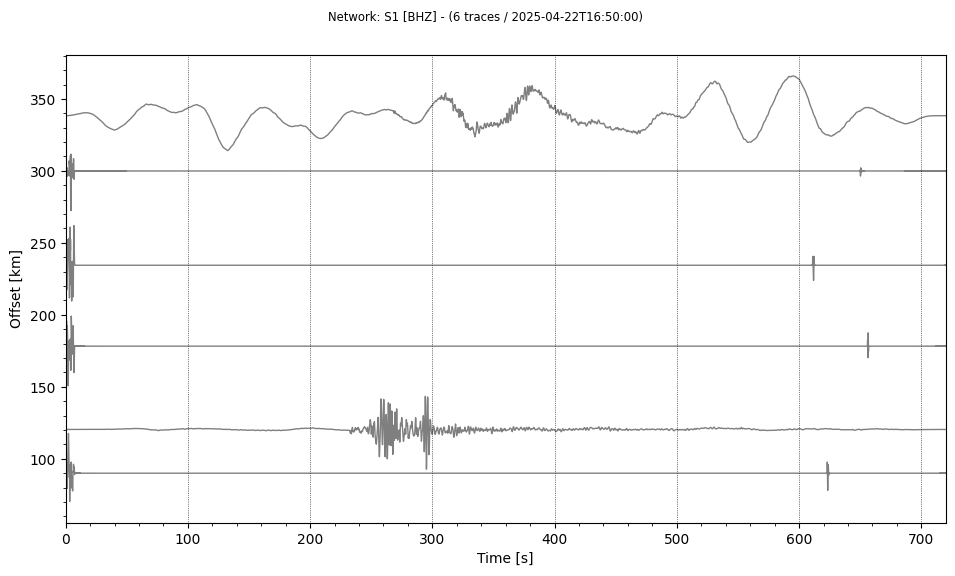

In [51]:
merged_signals.select(component='Z').plot(type='section', orientation='horizontal', starttime=obspy.UTCDateTime(2025,4,22,16,50,0), endtime=obspy.UTCDateTime(2025,4,22,17,5,0))

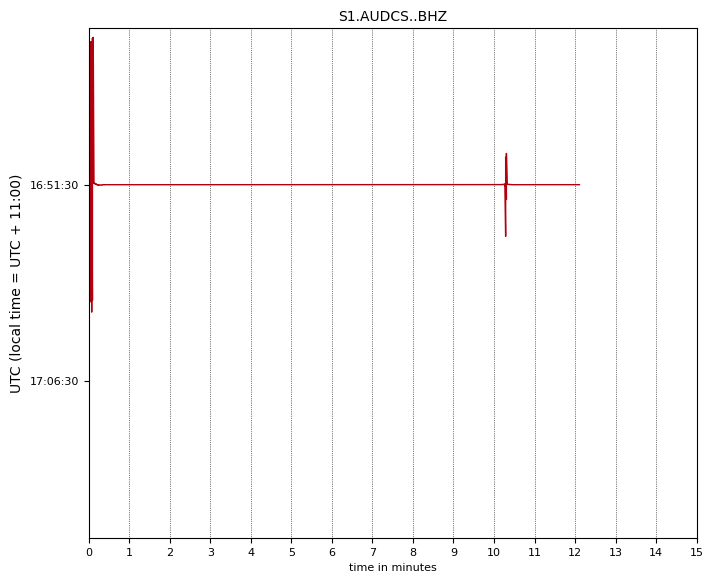

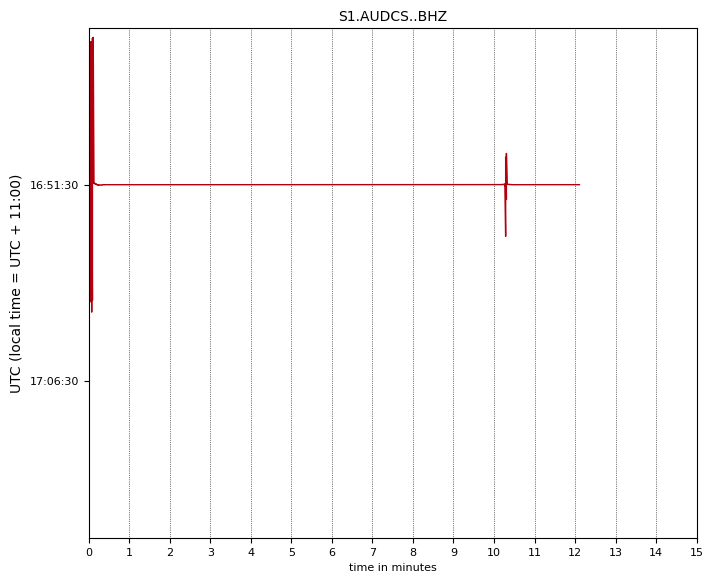

In [52]:
# checking appropriate frequency band
test_sig = merged_signals[3].copy()
# test_sig.filter('bandpass', freqmin=1, freqmax=1, corners=3, zerophase=True)
test_sig.filter('bandpass', freqmin=0.05, freqmax=2, corners=3, zerophase=True)
test_sig.plot(type='dayplot') # starttime=obspy.UTCDateTime(2025,4,22,16,55,0), endtime=obspy.UTCDateTime(2025,4,22,17,0,0)


c:\Users\thele\anaconda3\envs\base2\Lib\site-packages\obspy\imaging\spectrogram.py:144: RuntimeWarning: divide by zero encountered in log10
  specgram = 10 * np.log10(specgram[1:, :])
c:\Users\thele\anaconda3\envs\base2\Lib\site-packages\obspy\imaging\spectrogram.py:155: RuntimeWarning: invalid value encountered in scalar add
  vmax = specgram.min() + vmax * _range


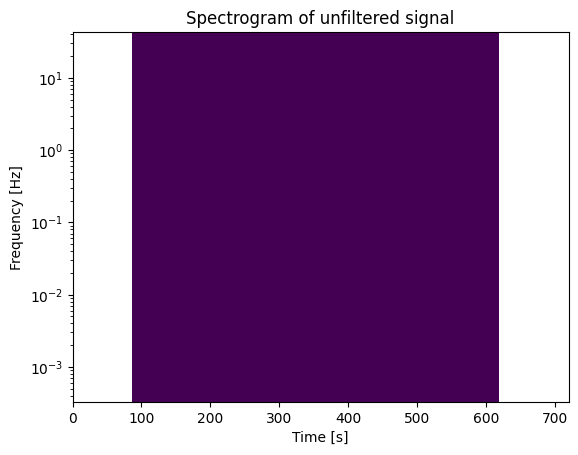

In [53]:
toast = merged_signals[0].copy()
toast.trim(starttime=obspy.UTCDateTime(2025,4,22,16,40,0), endtime=obspy.UTCDateTime(2025,4,22,17,15,0))

toast.spectrogram(log=True, title='Spectrogram of unfiltered signal', wlen=256, dbscale=True)

In [54]:
merged_signals[0]

S1.AUKHS..BHZ | 2025-04-22T16:51:30.000000Z - 2025-04-22T17:03:29.988387Z | 86.1 Hz, 62000 samples

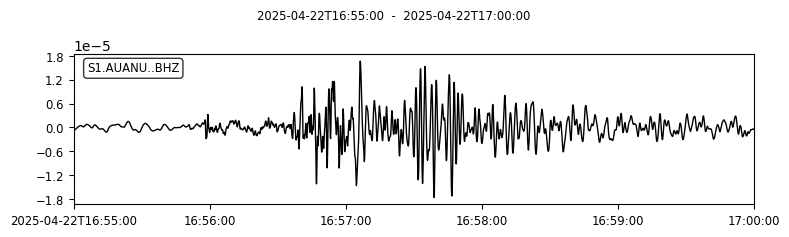

In [55]:
plote = signals_filt2[0].plot(starttime=obspy.UTCDateTime(2025,4,22,16,55,0), endtime=obspy.UTCDateTime(2025,4,22,17,0,0))

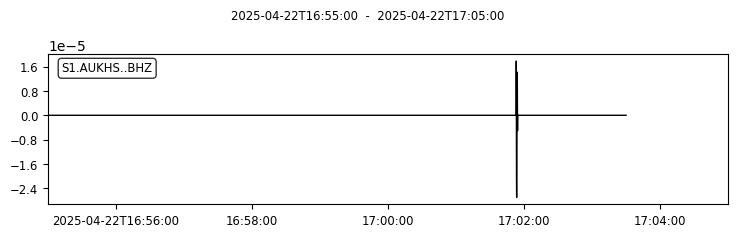

In [56]:
plote = merged_signals[0].plot(starttime=obspy.UTCDateTime(2025,4,22,16,55,0), endtime=obspy.UTCDateTime(2025,4,22,17,5,0))

In [57]:
secs_offset2 = [400,          0,    100,     50,    60,      200]
cols_offset2 = ['black', 'blue', 'green', 'red', 'purple', 'orange']

In [58]:
signals_geq_filt2

10 Trace(s) in Stream:
S1.AUANU..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 64001 samples
S1.AUDCS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:00:50.900000Z | 10.0 Hz, 37510 samples
S1.AUDCS..BHZ | 2025-04-22T17:01:41.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 25991 samples
S1.AUKHS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:01:02.900000Z | 10.0 Hz, 37630 samples
S1.AUKHS..BHZ | 2025-04-22T17:01:53.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 25871 samples
S1.AUPHS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:00:45.900000Z | 10.0 Hz, 37460 samples
S1.AUPHS..BHZ | 2025-04-22T17:02:26.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 25541 samples
S1.AUTKS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 64001 samples
S1.AUUHS..BHZ | 2025-04-22T15:58:20.000000Z - 2025-04-22T17:00:39.900000Z | 10.0 Hz, 37400 samples
S1.AUUHS..BHZ | 2025-04-22T17:02:20.000000Z - 2025-04-22T17:45:00.000000Z | 10.0 Hz, 2

0
1
2
3
4
5
6
7
8
9


C:\Users\thele\AppData\Local\Temp\ipykernel_27964\448170888.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


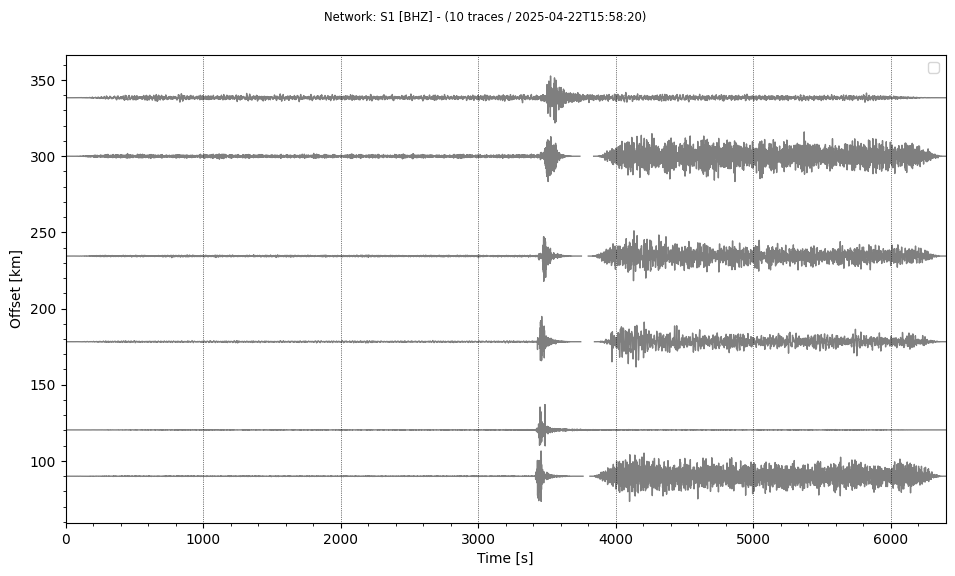

In [59]:
# Plot section and get the figure
fig = signals_filt2.select(component='Z').plot(type='section', orientation='horizontal', show=False)

# Get the correct axes
ax = fig.axes[0]

# Get event time as matplotlib date
event_time_dt = obspy.UTCDateTime(event_time).datetime
event_time_num = mdates.date2num(event_time_dt)

secs_offset2 = [240,          0,     50,    60,      160,      10]
cols_offset2 = ['black', 'blue', 'red', 'purple', 'orange', 'pink']

# Overlay the second set of traces (e.g., signals_geq_filt)
for i, tr in enumerate(signals_geq_filt2.select(component='Z')):
    # Calculate time axis in seconds since event
    print(i)
    t = tr.times()
    # Calculate distance in km
    y = tr.stats.distance / 1000
    # Offset for plotting (match ObsPy's section plot style)
    #ax.plot(t+secs_offset2[i], np.ones_like(t) * (y-5) + tr.data / np.max(np.abs(tr.data)) * 55, color=cols_offset2[i], alpha=0.5)

# for i, tr in enumerate(signals_filt.select(component='Z')):
#     # Calculate time axis in seconds since event
#     t = tr.times()
#     # Calculate distance in km
#     y = tr.stats.distance / 1000
#     # Offset for plotting (match ObsPy's section plot style)
#     ax.plot(t+secs_offset[i], np.ones_like(t) * (y) + tr.data / np.max(np.abs(tr.data)) * 55, color=cols_offset[i], alpha=0.7)

# Get max distance for y axis
max_dist = max([tr.stats.distance for tr in signals_filt2.select(component='Z')]) / 1000  # km

# # Generate points for the line
# y = np.linspace(0, 1120, 1000)
# t = y / 2.95 + 3200 # event time relative to start of BYRD
# t_p = y / 6.0 + 3200
# t_s = y / 4.0 + 3200
# # Plot the red line on the same axes
# ax.plot(t, y, 'k-', lw=2, label='GEQ (2.95 km/s)')
# ax.plot(t_p, y, 'r-', lw=2, label='P-wave (6.0 km/s)')
# ax.plot(t_s, y, 'g-', lw=2, label='S-wave (4.0 km/s)')

#ax.set_ylim(200, 1120)
#ax.set_xlim(2500, 4000)


ax.legend()

# Instead of plt.show(), display the figure directly in Jupyter:
fig.canvas.draw()
fig